# Contenidos

Arima: 
- log return
- Interpretacion coeficientes, aic bic y tests
- forecasting
- arreglar, legolizar y atomizar funciones
- cada codigo debe ser dominado a la perfeccion!
- {""}, [""], abrir y cerrar de una, luego meterse dentro y escribir
- escribir las variables completas, no pasa nada con escribir demas!

Esqueleto:

Para cada activo financiero y 3 ventanas de estimacion

1) Datos:
- Rellenar espacios [x]
- Dataframe con log_returns [x]
- Resumen:
    - Resumen descriptivo
    - Graficos
    - Histogramas
    - tests

2) Benchmarks [x]
- Naive Forecast [x]
- RW [x]

3) Exp Smoo []
- Moving Average [x]
- SES [x]
- Holt [] pend
- Holt-Winter [] pend
- Resumen predicciones []

4) ARIMA [] 
- Arima modeling [x]
- Forecast [x]
- Interpretacion summary() (test, aic, coeficientes, etc) [x]

5) VAR []
- Definir vector adicional []
- modelar e interpretar coeficientes []
- forecast []

6) Garch [x]

7) Resumen tablas
- MSE, MSFE, MAE
- R2 (Completo, IS y OOS?)
- AIC y BIC
- Log Likelihood

- Benchmarks [] []
- Exponential Smoothing [] [] []
- ARIMA[]
- VAR []
- GARCH []

# Librerias

In [ ]:
%%time

# libraries
import pandas as pd
import numpy as np

from arch import arch_model
from importlib import reload

#import common.common_functions as ccf; reload(ccf)

import data_management.data_storage as dmds; reload(dmds)
import data_management.data_acquisition as dmda; reload(dmda)
from data_management.data_storage import RDS
from data_management.data_acquisition import EOD

import datetime as dt
import datetime
from dateutil import tz
from dateutil import parser



from transform.foreign_exchange import FX

import itertools

import matplotlib.pyplot as plt

import os

import pmdarima as pm
from pathlib import Path
import pytz

import requests_cache

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import statsmodels.api as sm

CPU times: user 3.32 s, sys: 1.59 s, total: 4.91 s
Wall time: 2.09 s


# Datos

## Datos - Filtros y ajustes
Primera observacion: 2020-02-03 09:01:00

Ultima observacion: 2020-05-25 17:59:00



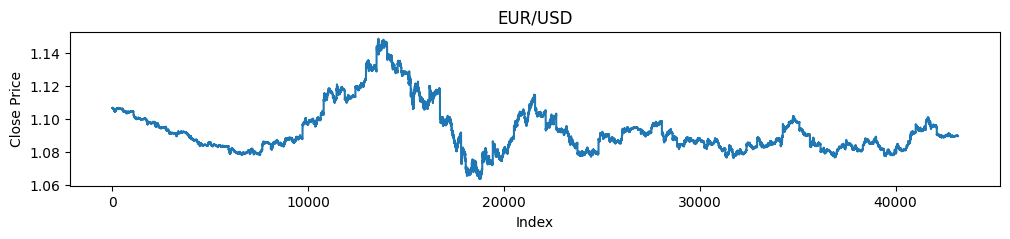

In [ ]:
df = pd.read_csv("extraccion.csv")
euro_df = df
euro_df = euro_df.drop_duplicates(subset="Unnamed: 0", keep="first")
euro_df = euro_df.set_index(pd.to_datetime(euro_df.loc[:, "Unnamed: 0"])).sort_index()
euro_df = euro_df.drop("Unnamed: 0", axis=1).rename_axis("datetime").reset_index()

euro_df["price_close"].plot(subplots=True, figsize=(12,2))
plt.plot;
plt.xlabel("Index");
plt.ylabel("Close Price");
plt.title("EUR/USD");

price_close_s = euro_df["price_close"].copy()

euro_df["log_return"] = np.log(euro_df["price_close"]).diff()
euro_df = euro_df.iloc[1:]
euro_df = euro_df.drop("price_close", axis=1).reset_index().drop("index", axis=1)



# minutes_s = euro_df.reset_index()["datetime"].diff().apply(lambda x: x.seconds / 60 if not pd.isnull(x) else 0)
# for i in range(len(minutes_s)):
#     if minutes_s[i] != 1:
#         print(minutes_s[i], i)

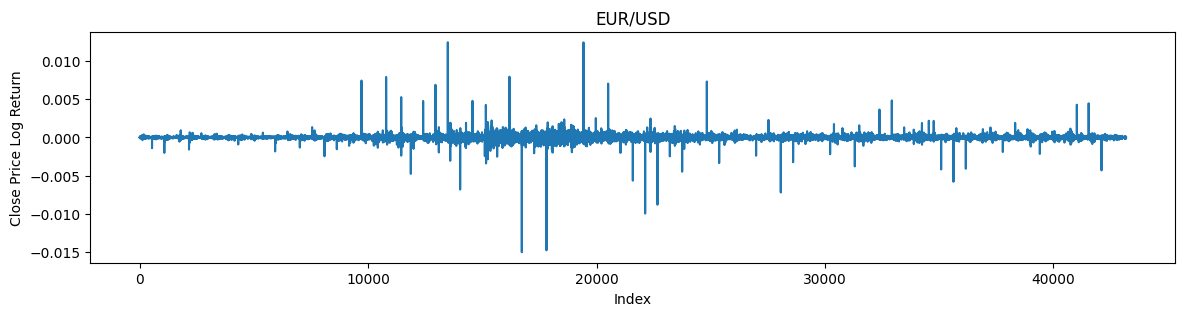

In [ ]:
euro_df["log_return"].plot(figsize=(14,3));
plt.plot;
plt.xlabel("Index");
plt.ylabel("Close Price Log Return");
plt.title("EUR/USD");

## Resumen de datos

,count,mean,std,min,25%,50%,75%,max
log_return,43180.0,-3.568554e-07,0.000296,-0.015023,-0.000083,0.0,0.000083,0.012452


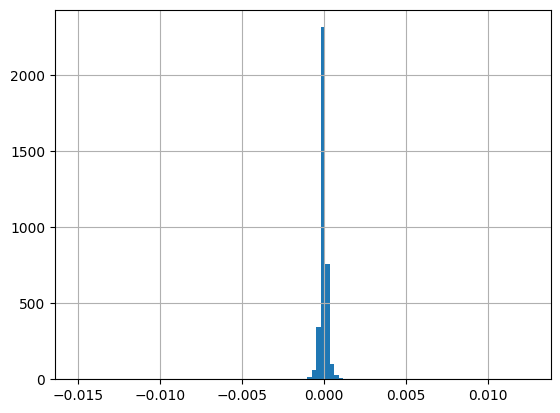

In [ ]:
euro_df["log_return"].hist(bins=100, density=True);
pd.DataFrame(euro_df["log_return"].describe()).T

# Train & Test

Ventanas de estimación:
P: Forecast data / testeo
R: Train Data / entrenamiento
T: Total Data  (P + R)



P/R = 2

P/R = 1

P/R = 0.4


In [ ]:
## Ventana de estimación P/R=2:

In [ ]:
P_R = 2
ntest2=int(len(euro_df) * (P_R/(1+P_R)))

train_2_euro_df = euro_df.iloc[:-ntest2]
test_2_euro_df = euro_df.iloc[-ntest2:]

# Returns (log difference)
train_2_euro_ret_s = train_2_euro_df["log_return"]
test_2_euro_ret_s = test_2_euro_df["log_return"]

# Index boolean
train_2_euro_idx = euro_df.index <= train_2_euro_df.index[-1]
test_2_euro_idx = euro_df.index > train_2_euro_df.index[-1]

euro_2_df = euro_df.copy()

train_price_2_s = price_close_s[:-ntest2]
test_price_2_s = price_close_s[-ntest2:]

In [ ]:
### Escalamiento 

In [ ]:
train_2_euro_mean = train_2_euro_ret_s.mean()
test_2_euro_mean = test_2_euro_ret_s.mean()
train_2_euro_std = train_2_euro_ret_s.std()
test_2_euro_std = test_2_euro_ret_s.std()

train_2_euro_df.loc[:,"Scaled 2"] = ((train_2_euro_ret_s - train_2_euro_mean) / train_2_euro_std).copy()
test_2_euro_df.loc[:,"Scaled 2"] = ((test_2_euro_ret_s - test_2_euro_mean) / test_2_euro_std).copy()

euro_2_df.loc[train_2_euro_idx,"Scaled 2"] = ((train_2_euro_ret_s - train_2_euro_mean) / train_2_euro_std).copy()
euro_2_df.loc[test_2_euro_idx,"Scaled 2"] = ((test_2_euro_ret_s - test_2_euro_mean) / test_2_euro_std).copy()

train_2_scaled_euro_ret_s = pd.Series(((train_2_euro_ret_s.to_numpy() - train_2_euro_mean) / train_2_euro_std).copy())
test_2_scaled_euro_ret_s = pd.Series(((test_2_euro_ret_s - test_2_euro_mean) / test_2_euro_std).copy())

/var/folders/vp/8_fwbzwx48nfbpk6qt_4yb740000gn/T/ipykernel_11005/2774752115.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2_euro_df.loc[:,"Scaled 2"] = ((train_2_euro_ret_s - train_2_euro_mean) / train_2_euro_std).copy()
/var/folders/vp/8_fwbzwx48nfbpk6qt_4yb740000gn/T/ipykernel_11005/2774752115.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2_euro_df.loc[:,"Scaled 2"] = ((test_2_euro_ret_s - test_2_euro_mean) / test_2_euro_std).copy()


In [ ]:
## Ventana de estimación P/R=1:

In [ ]:
P_R = 1
ntest1=int(len(euro_df) * (P_R/(1+P_R)))

train_1_euro_df = euro_df.iloc[:-ntest1]
test_1_euro_df = euro_df.iloc[-ntest1:]

# Returns (log difference)
train_1_euro_ret_s = train_1_euro_df["log_return"]
test_1_euro_ret_s = test_1_euro_df["log_return"]

# Index boolean
train_1_euro_idx = euro_df.index <= train_1_euro_df.index[-1]
test_1_euro_idx = euro_df.index > train_1_euro_df.index[-1]

euro_1_df = euro_df.copy()

train_price_1_s = price_close_s[:-ntest1]
test_price_1_s = price_close_s[-ntest1:]

In [ ]:
### Escalamiento 

In [ ]:
train_1_euro_mean = train_1_euro_ret_s.mean()
test_1_euro_mean = test_1_euro_ret_s.mean()
train_1_euro_std = train_1_euro_ret_s.std()
test_1_euro_std = test_1_euro_ret_s.std()

train_1_euro_df.loc[:,"Scaled 1"] = ((train_1_euro_ret_s - train_1_euro_mean) / train_1_euro_std).copy()
test_1_euro_df.loc[:,"Scaled 1"] = ((test_1_euro_ret_s - test_1_euro_mean) / test_1_euro_std).copy()

euro_1_df.loc[train_1_euro_idx,"Scaled 1"] = ((train_1_euro_ret_s - train_1_euro_mean) / train_1_euro_std).copy()
euro_1_df.loc[test_1_euro_idx,"Scaled 1"] = ((test_1_euro_ret_s - test_1_euro_mean) / test_1_euro_std).copy()

train_1_scaled_euro_ret_s = pd.Series(((train_1_euro_ret_s - train_1_euro_mean) / train_1_euro_std).copy())
test_1_scaled_euro_ret_s = pd.Series(((test_1_euro_ret_s - test_1_euro_mean) / test_1_euro_std).copy())

/var/folders/vp/8_fwbzwx48nfbpk6qt_4yb740000gn/T/ipykernel_11005/2204481751.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_1_euro_df.loc[:,"Scaled 1"] = ((train_1_euro_ret_s - train_1_euro_mean) / train_1_euro_std).copy()
/var/folders/vp/8_fwbzwx48nfbpk6qt_4yb740000gn/T/ipykernel_11005/2204481751.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1_euro_df.loc[:,"Scaled 1"] = ((test_1_euro_ret_s - test_1_euro_mean) / test_1_euro_std).copy()


In [ ]:
P_R = 1
ntest1=int(len(euro_df) * (P_R/(1+P_R)))

train_1_euro_df = euro_df.iloc[:-ntest1]
test_1_euro_df = euro_df.iloc[-ntest1:]

# Returns (log difference)
train_1_euro_ret_s = train_1_euro_df["log_return"]
test_1_euro_ret_s = test_1_euro_df["log_return"]

# Index boolean
train_1_euro_idx = euro_df.index <= train_1_euro_df.index[-1]
test_1_euro_idx = euro_df.index > train_1_euro_df.index[-1]

euro_1_df = euro_df.copy()

# Escalamiento

train_1_euro_mean = train_1_euro_ret_s.mean()
test_1_euro_mean = test_1_euro_ret_s.mean()
train_1_euro_std = train_1_euro_ret_s.std()
test_1_euro_std = test_1_euro_ret_s.std()

train_1_euro_df.loc[:,"Scaled 1"] = ((train_1_euro_ret_s - train_1_euro_mean) / train_1_euro_std).copy()
test_1_euro_df.loc[:,"Scaled 1"] = ((test_1_euro_ret_s - test_1_euro_mean) / test_1_euro_std).copy()

euro_1_df.loc[train_1_euro_idx,"Scaled 1"] = ((train_1_euro_ret_s - train_1_euro_mean) / train_1_euro_std).copy()
euro_1_df.loc[test_1_euro_idx,"Scaled 1"] = ((test_1_euro_ret_s - test_1_euro_mean) / test_1_euro_std).copy()

train_1_scaled_euro_ret_s = pd.Series(((train_1_euro_ret_s - train_1_euro_mean) / train_1_euro_std).copy())
test_1_scaled_euro_ret_s = pd.Series(((test_1_euro_ret_s - test_1_euro_mean) / test_1_euro_std).copy())

/var/folders/vp/8_fwbzwx48nfbpk6qt_4yb740000gn/T/ipykernel_11005/4230793291.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_1_euro_df.loc[:,"Scaled 1"] = ((train_1_euro_ret_s - train_1_euro_mean) / train_1_euro_std).copy()
/var/folders/vp/8_fwbzwx48nfbpk6qt_4yb740000gn/T/ipykernel_11005/4230793291.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1_euro_df.loc[:,"Scaled 1"] = ((test_1_euro_ret_s - test_1_euro_mean) / test_1_euro_std).copy()


In [ ]:
## Ventana de estimación P/R=0.4:

In [ ]:
P_R = 0.4
ntest04=int(len(euro_df) * (P_R/(1+P_R)))

train_04_euro_df = euro_df.iloc[:-ntest04]
test_04_euro_df = euro_df.iloc[-ntest04:]

# Returns (log difference)
train_04_euro_ret_s = train_04_euro_df["log_return"]
test_04_euro_ret_s = test_04_euro_df["log_return"]

# Index boolean
train_04_euro_idx = euro_df.index <= train_04_euro_df.index[-1]
test_04_euro_idx = euro_df.index > train_04_euro_df.index[-1]

euro_04_df = euro_df.copy()

train_price_04_s = price_close_s[:-ntest04]
test_price_04_s = price_close_s[-ntest04:]

In [ ]:
### Escalamiento 

In [415]:
train_04_euro_mean = train_04_euro_ret_s.mean()
test_04_euro_mean = test_04_euro_ret_s.mean()
train_04_euro_std = train_04_euro_ret_s.std()
test_04_euro_std = test_04_euro_ret_s.std()

train_04_euro_df.loc[:,"Scaled 04"] = ((train_04_euro_ret_s - train_04_euro_mean) / train_04_euro_std).copy()
test_04_euro_df.loc[:,"Scaled 04"] = ((test_04_euro_ret_s - test_04_euro_mean) / test_04_euro_std).copy()

euro_04_df.loc[train_04_euro_idx,"Scaled 04"] = ((train_04_euro_ret_s - train_04_euro_mean) / train_04_euro_std).copy()
euro_04_df.loc[test_04_euro_idx,"Scaled 04"] = ((test_04_euro_ret_s - test_04_euro_mean) / test_04_euro_std).copy()

train_04_scaled_euro_ret_s = pd.Series(((train_04_euro_ret_s - train_04_euro_mean) / train_04_euro_std).copy())
test_04_scaled_euro_ret_s = pd.Series(((test_04_euro_ret_s - test_04_euro_mean) / test_04_euro_std).copy())

/var/folders/vp/8_fwbzwx48nfbpk6qt_4yb740000gn/T/ipykernel_69097/2909132050.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_04_euro_df.loc[:,"Scaled 04"] = ((train_04_euro_ret_s - train_04_euro_mean) / train_04_euro_std).copy()
/var/folders/vp/8_fwbzwx48nfbpk6qt_4yb740000gn/T/ipykernel_69097/2909132050.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_04_euro_df.loc[:,"Scaled 04"] = ((test_04_euro_ret_s - test_04_euro_mean) / test_04_euro_std).copy()


# Benchmarks

## Geometric Brownian Motion 

In [416]:
# simulaciones de montecarlo

def simul_ret(mu, sigma, paths=1, num_obs=500):
    error_df = pd.DataFrame(np.random.normal(loc=0, scale=1, size=(num_obs, paths)))
    ret_df = mu + sigma * error_df
    return ret_df 

In [417]:
### P/R = 2

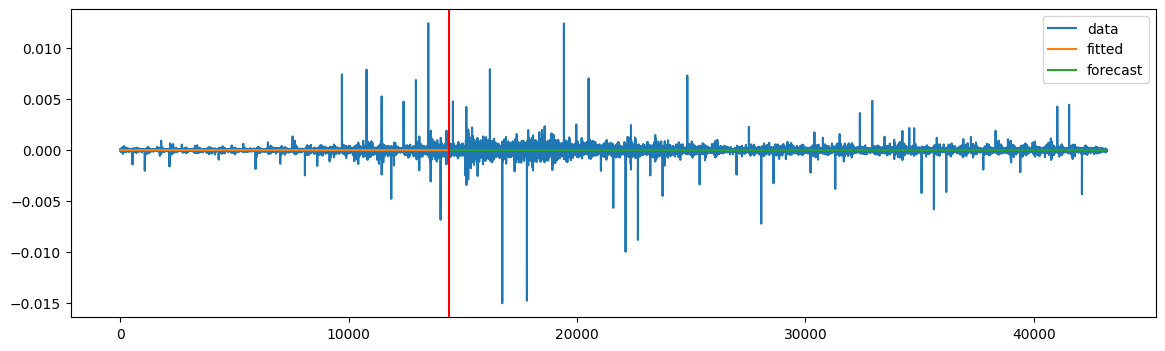

In [418]:
simul_2_gbm_ret_df = simul_ret(train_2_euro_mean, train_2_euro_std, paths=100000, num_obs=500)
mu_gbm_2 = simul_2_gbm_ret_df.mean().mean()
gbm_train_2_s = pd.Series(mu_gbm_2, index=train_2_euro_ret_s.index)
gbm_test_2_s = pd.Series(mu_gbm_2, index=test_2_euro_ret_s.index)
euro_2_df.loc[train_2_euro_idx, "GBM"] = gbm_train_2_s
euro_2_df.loc[test_2_euro_idx, "GBM"] = gbm_test_2_s

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(euro_2_df["log_return"].index, euro_2_df["log_return"], label="data")
ax.plot(train_2_euro_ret_s.index, gbm_train_2_s, label="fitted")
ax.plot(test_2_euro_ret_s.index, gbm_test_2_s, label="forecast")
ax.legend()
plt.axvline(len(euro_df)-ntest2, label="P/R", color="red");

In [419]:
### P/R = 1

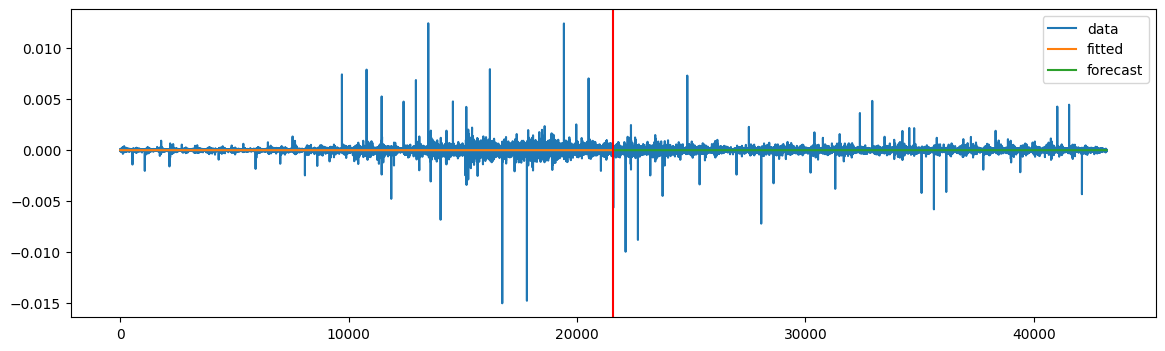

In [420]:
simul_1_gbm_ret_df = simul_ret(train_1_euro_mean, train_1_euro_std, paths=100000, num_obs=500)
mu_gbm_1 = simul_1_gbm_ret_df.mean().mean()
gbm_train_1_s = pd.Series(mu_gbm_1, index=train_1_euro_ret_s.index)
gbm_test_1_s = pd.Series(mu_gbm_1, index=test_1_euro_ret_s.index)
euro_1_df.loc[train_1_euro_idx, "GBM"] = gbm_train_1_s
euro_1_df.loc[test_1_euro_idx, "GBM"] = gbm_test_1_s

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(euro_1_df["log_return"].index, euro_1_df["log_return"], label="data")
ax.plot(train_1_euro_ret_s.index, gbm_train_1_s, label="fitted")
ax.plot(test_1_euro_ret_s.index, gbm_test_1_s, label="forecast")
ax.legend()
plt.axvline(len(euro_df)-ntest1, label="P/R", color="red");

In [421]:
### P/R = 0.4

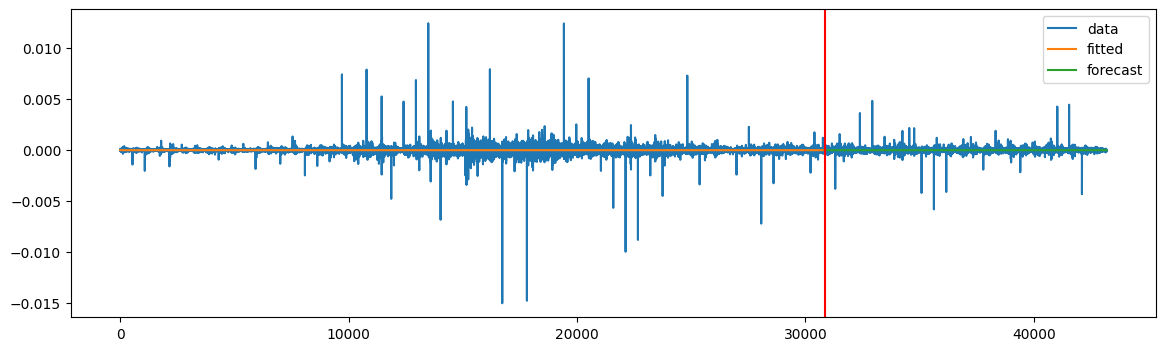

In [422]:
simul_04_gbm_ret_df = simul_ret(train_04_euro_mean, train_04_euro_std, paths=100000, num_obs=500)
mu_gbm_04 = simul_04_gbm_ret_df.mean().mean()
gbm_train_04_s = pd.Series(mu_gbm_04, index=train_04_euro_ret_s.index)
gbm_test_04_s = pd.Series(mu_gbm_04, index=test_04_euro_ret_s.index)
euro_04_df.loc[train_04_euro_idx, "GBM"] = gbm_train_04_s
euro_04_df.loc[test_04_euro_idx, "GBM"] = gbm_test_04_s

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(euro_04_df["log_return"].index, euro_04_df["log_return"], label="data")
ax.plot(train_04_euro_ret_s.index, gbm_train_04_s, label="fitted")
ax.plot(test_04_euro_ret_s.index, gbm_test_04_s, label="forecast")
ax.legend()
plt.axvline(len(euro_df)-ntest04, label="P/R", color="red");

## Random Walk 

In [423]:
### P/R = 2

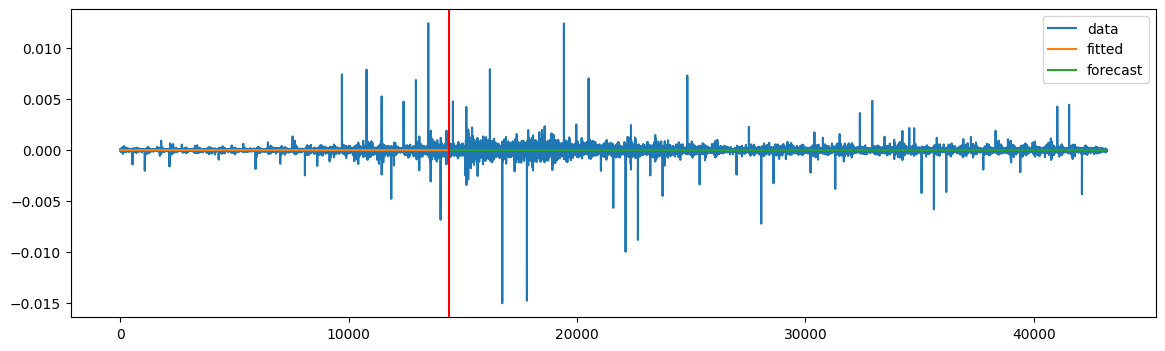

In [424]:
simul_2_randomwalk_ret_df = simul_ret(0, train_2_euro_std, paths=100000, num_obs=500)
mu_randomwalk_2 = simul_2_gbm_ret_df.mean().mean()
random_walk_train_2_s = pd.Series(mu_randomwalk_2, index=train_2_euro_ret_s.index)
random_walk_test_2_s = pd.Series(mu_randomwalk_2, index=test_2_euro_ret_s.index)
euro_2_df.loc[train_2_euro_idx, "Random Walk"] = random_walk_train_2_s
euro_2_df.loc[test_2_euro_idx, "Random Walk"] = random_walk_test_2_s

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(euro_2_df["log_return"].index, euro_2_df["log_return"], label="data")
ax.plot(train_2_euro_ret_s.index, random_walk_train_2_s, label="fitted")
ax.plot(test_2_euro_ret_s.index, random_walk_test_2_s, label="forecast")
ax.legend()
plt.axvline(len(euro_df)-ntest2, label="P/R", color="red");

In [425]:
### P/R = 1

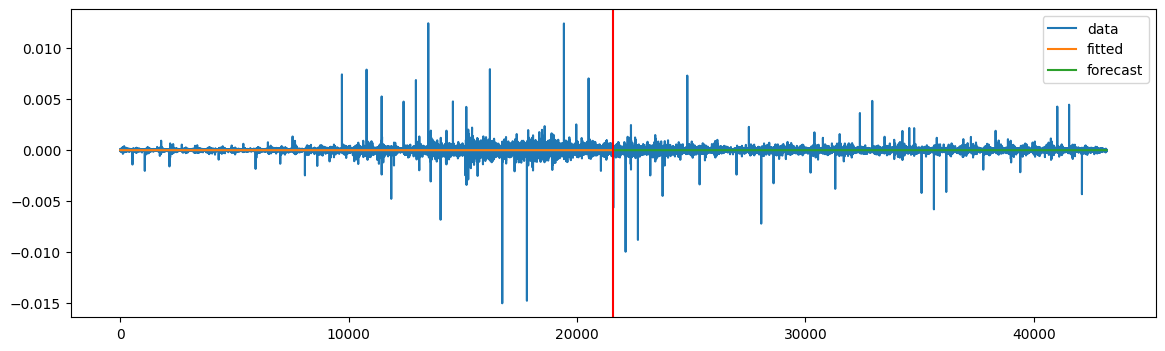

In [426]:
simul_1_randomwalk_ret_df = simul_ret(0, train_1_euro_std, paths=100000, num_obs=500)
mu_randomwalk_1 = simul_1_gbm_ret_df.mean().mean()
random_walk_train_1_s = pd.Series(mu_randomwalk_1, index=train_1_euro_ret_s.index)
random_walk_test_1_s = pd.Series(mu_randomwalk_1, index=test_1_euro_ret_s.index)
euro_1_df.loc[train_1_euro_idx, "Random Walk"] = random_walk_train_1_s
euro_1_df.loc[test_1_euro_idx, "Random Walk"] = random_walk_test_1_s

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(euro_1_df["log_return"].index, euro_1_df["log_return"], label="data")
ax.plot(train_1_euro_ret_s.index, random_walk_train_1_s, label="fitted")
ax.plot(test_1_euro_ret_s.index, random_walk_test_1_s, label="forecast")
ax.legend()
plt.axvline(len(euro_df)-ntest1, label="P/R", color="red");

In [427]:
### P/R = 0.4

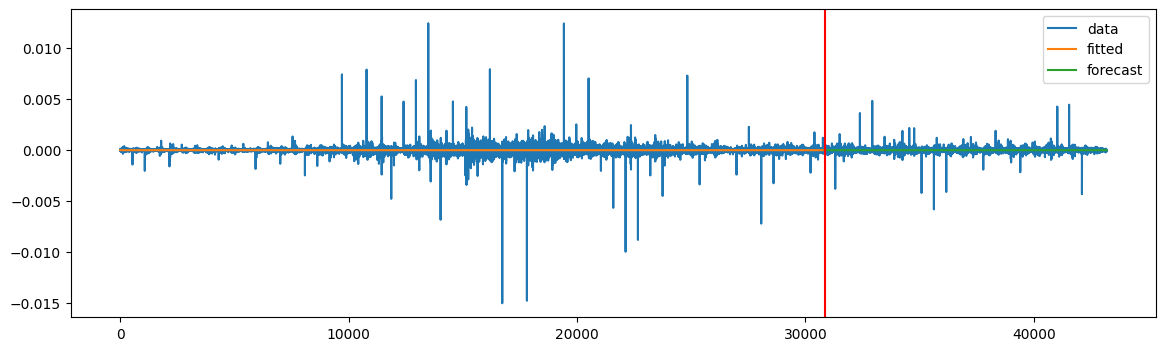

In [428]:
simul_04_randomwalk_ret_df = simul_ret(0, train_04_euro_std, paths=100000, num_obs=500)
mu_randomwalk_04 = simul_04_gbm_ret_df.mean().mean()
random_walk_train_04_s = pd.Series(mu_randomwalk_04, index=train_04_euro_ret_s.index)
random_walk_test_04_s = pd.Series(mu_randomwalk_04, index=test_04_euro_ret_s.index)
euro_04_df.loc[train_04_euro_idx, "Random Walk"] = random_walk_train_04_s
euro_04_df.loc[test_04_euro_idx, "Random Walk"] = random_walk_test_04_s

fig, ax = plt.subplots(figsize=(14,4))
ax.plot(euro_04_df["log_return"].index, euro_04_df["log_return"], label="data")
ax.plot(train_04_euro_ret_s.index, random_walk_train_04_s, label="fitted")
ax.plot(test_04_euro_ret_s.index, random_walk_test_04_s, label="forecast")
ax.legend()
plt.axvline(len(euro_df)-ntest04, label="P/R", color="red");

## Naive Forecast

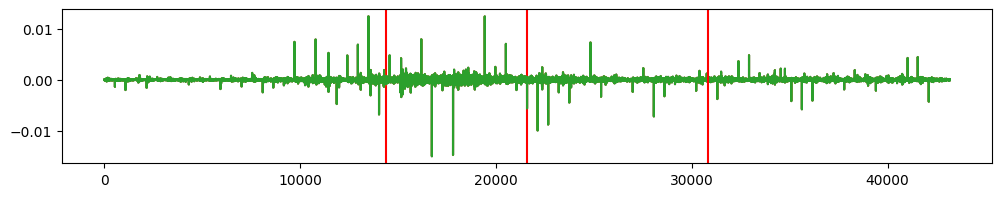

In [429]:
### P/R=2
naive_euro_train_2_s = train_2_euro_ret_s.shift(1).iloc[1:]
naive_euro_test_2_s = test_2_euro_ret_s.shift(1).iloc[1:]

euro_2_df.loc[train_2_euro_idx, "Naive Forecast"] = naive_euro_train_2_s
euro_2_df.loc[test_2_euro_idx, "Naive Forecast"] = naive_euro_test_2_s
euro_2_df["Naive Forecast"].plot(figsize=(12,2));
plt.axvline(len(euro_df)-ntest2, label="P/R", color="red")


### P/R=1
naive_euro_train_1_s = train_1_euro_ret_s.shift(1).iloc[1:]
naive_euro_test_1_s = test_1_euro_ret_s.shift(1).iloc[1:]

euro_1_df.loc[train_1_euro_idx, "Naive Forecast"] = naive_euro_train_1_s
euro_1_df.loc[test_1_euro_idx, "Naive Forecast"] = naive_euro_test_1_s
euro_1_df["Naive Forecast"].plot(figsize=(12,2));
plt.axvline(len(euro_df)-ntest1, label="P/R", color="red")


### P/R=0.4
naive_euro_train_04_s = train_04_euro_ret_s.shift(1).iloc[1:]
naive_euro_test_04_s = test_04_euro_ret_s.shift(1).iloc[1:]

euro_04_df.loc[train_04_euro_idx, "Naive Forecast"] = naive_euro_train_04_s
euro_04_df.loc[test_04_euro_idx, "Naive Forecast"] = naive_euro_test_04_s
euro_04_df["Naive Forecast"].plot(figsize=(12,2));
plt.axvline(len(euro_df)-ntest04, label="P/R", color="red")

## Resumen

In [ ]:
rmse_train_gbm_ls = [np.sqrt(mean_squared_error(train_2_euro_ret_s, gbm_train_2_s)),
          np.sqrt(mean_squared_error(train_1_euro_ret_s, gbm_train_1_s)),
          np.sqrt(mean_squared_error(train_04_euro_ret_s, gbm_train_04_s))]

rmse_test_gbm_ls = [np.sqrt(mean_squared_error(test_2_euro_ret_s, gbm_test_2_s)),
          np.sqrt(mean_squared_error(test_1_euro_ret_s, gbm_test_1_s)),
          np.sqrt(mean_squared_error(test_04_euro_ret_s, gbm_test_04_s))]
          
rmse_train_randomwalk_ls = [np.sqrt(mean_squared_error(train_2_euro_ret_s, random_walk_train_2_s)),
          np.sqrt(mean_squared_error(train_1_euro_ret_s, random_walk_train_1_s)),
          np.sqrt(mean_squared_error(train_04_euro_ret_s, random_walk_train_04_s))]

rmse_test_randomwalk_ls = [np.sqrt(mean_squared_error(test_2_euro_ret_s, random_walk_test_2_s)),
          np.sqrt(mean_squared_error(test_1_euro_ret_s, random_walk_test_1_s)),
          np.sqrt(mean_squared_error(test_04_euro_ret_s, random_walk_test_04_s))]

rmse_train_naive_ls = [np.sqrt(mean_squared_error(train_2_euro_ret_s.iloc[1:], naive_euro_train_2_s)),
          np.sqrt(mean_squared_error(train_1_euro_ret_s.iloc[1:], naive_euro_train_1_s)),
          np.sqrt(mean_squared_error(train_04_euro_ret_s.iloc[1:], naive_euro_train_04_s))]

rmse_test_naive_ls = [np.sqrt(mean_squared_error(test_2_euro_ret_s.iloc[1:], naive_euro_test_2_s)),
          np.sqrt(mean_squared_error(test_1_euro_ret_s.iloc[1:], naive_euro_test_1_s)),
          np.sqrt(mean_squared_error(test_04_euro_ret_s.iloc[1:], naive_euro_test_04_s))]

r2_train_gbm_ls = [r2_score(train_2_euro_ret_s, gbm_train_2_s),
          r2_score(train_1_euro_ret_s, gbm_train_1_s),
          r2_score(train_04_euro_ret_s, gbm_train_04_s)]

r2_test_gbm_ls = [r2_score(test_2_euro_ret_s, gbm_test_2_s),
          r2_score(test_1_euro_ret_s, gbm_test_1_s),
          r2_score(test_04_euro_ret_s, gbm_test_04_s)]

r2_train_randomwalk_ls = [r2_score(train_2_euro_ret_s, random_walk_train_2_s),
          r2_score(train_1_euro_ret_s, random_walk_train_1_s),
          r2_score(train_04_euro_ret_s, random_walk_train_04_s)]

r2_test_randomwalk_ls = [r2_score(test_2_euro_ret_s, random_walk_test_2_s),
          r2_score(test_1_euro_ret_s, random_walk_test_1_s),
          r2_score(test_04_euro_ret_s, random_walk_test_04_s)]

r2_train_naive_ls = [r2_score(train_2_euro_ret_s.iloc[1:], naive_euro_train_2_s),
          r2_score(train_1_euro_ret_s.iloc[1:], naive_euro_train_1_s),
          r2_score(train_04_euro_ret_s.iloc[1:], naive_euro_train_04_s)]

r2_test_naive_ls = [r2_score(test_2_euro_ret_s.iloc[1:], naive_euro_test_2_s),
          r2_score(test_1_euro_ret_s.iloc[1:], naive_euro_test_1_s),
          r2_score(test_04_euro_ret_s.iloc[1:], naive_euro_test_04_s)]



names_df= pd.DataFrame(["RMSE", "RMSE", "RMSE", "RMSFE", "RMSFE", "RMSFE", "R2", "R2", "R2", "R2 OOS", "R2 OOS", "R2 OOS"])
benchmark_df= pd.DataFrame(["GBM", "Random Walk", "Naive Forecast", "GBM", "Random Walk", 
                            "Naive Forecast", "GBM", "Random Walk", "Naive Forecast", "GBM", "Random Walk", "Naive Forecast"])



resumen_bechmark_df = pd.concat([pd.DataFrame(rmse_train_gbm_ls),  pd.DataFrame(rmse_train_randomwalk_ls), 
                                 pd.DataFrame(rmse_train_naive_ls), pd.DataFrame(rmse_test_gbm_ls), 
                                 pd.DataFrame(rmse_test_randomwalk_ls), pd.DataFrame(rmse_train_naive_ls),
                                 pd.DataFrame(r2_train_gbm_ls), pd.DataFrame(r2_train_randomwalk_ls),
                                 pd.DataFrame(r2_train_naive_ls), pd.DataFrame(r2_test_gbm_ls),
                                 pd.DataFrame(r2_test_randomwalk_ls), pd.DataFrame(r2_test_naive_ls)],  axis=1).T.reset_index(drop=True)

resumen_bechmark_df = pd.concat([benchmark_df, names_df, resumen_bechmark_df], axis=1).T.reset_index(drop=True).T
resumen_bechmark_df = resumen_bechmark_df.set_index([1,0]).rename_axis(["Benchmark", "Metrica"]).rename({2:"P/R=2", 3:"P/R=1", 4:"P/R=0.4"}, axis=1)

resumen_bechmark_df

NameError: name 'np' is not defined

Se puede observar que GBM y RW tiene  valores similares dado que la media poblacional de los retornos es cercano a 0. 

Se puede observar que el Naive Forecast tiene mayor error cuadratico medio que los otros benchmarks tanto dentro como fuera de muestra

Al comparar los resultados dentro y fuera de muestra, se puede observar que dependiendo de la ventana de estimacion que se elija puede haber un sobreajuste o no.

# Exponential Smoothing

## Simple Exponential Smoothing (SES)

El Simple Exponential Smoothing es un metodo de modelamiento en donde cada dato corresponde al promedio ponderado (determinado por un alfa que representa el peso) entre el valor actual y la predicción anterior. Para los pronosticos fuera de muestra, las predicciones multi-step corresponden a una constante para toda la ventana de predicción, esta constante representa el promedio ponderado entre el último valor reportado de la muestra y la última predicción del modelo.

Este método realiza pronósticos como según la suma ponderada de las observaciones pasadas, de las cuales las más antiguos poseen menor peso que las más recientes según alfa que determina la ponderación de estos. 

Para modelar de manera manual, se toma un valor inicial según el criterio personal, generalmente el primer valor de la serie, y se pondera el valor inicial real de la serie con el valor predicho según el modelo y obtenemos la predicción para el siguiente periodo. Una vez obtenido el valor, este se promedia con el valor actual real y obtenemos una nueva predicción para el siguiente periodo y así sucesivamente. A medida que se realizan las predicciones, los valores iniciales disminuyen en peso.


Se dice que el SES es de especial utilidad para pronosticos de corto plazo

In [431]:
### P/R = 2

Dep. Variable:,log_return,No. Observations:,14394
Model:,SimpleExpSmoothing,SSE,0.001
Optimized:,True,AIC,-239632.152
Trend:,None,BIC,-239617.003
Seasonal:,None,AICC,-239632.149
Seasonal Periods:,None,Date:,"Wed, 07 Jun 2023"
Box-Cox:,False,Time:,15:18:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0050000,alpha,True
initial_level,-6.3262e-05,l.0,False


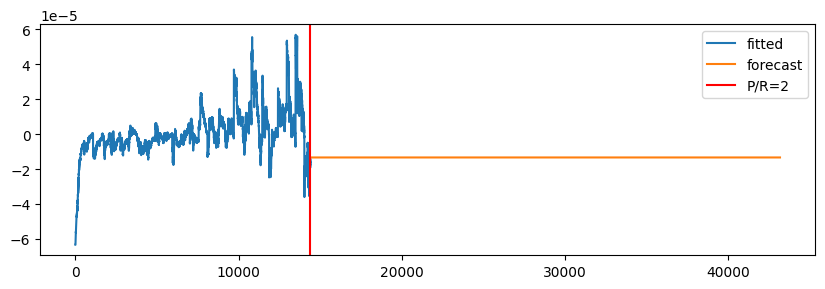

In [432]:
ses_2_object = SimpleExpSmoothing(train_2_euro_ret_s, 
                                initialization_method="legacy-heuristic")  # "legacy-heu" para definir cómo iniciar segun el primer valor
ses_2_model = ses_2_object.fit()
euro_2_df.loc[train_2_euro_idx, "SES"] = ses_2_model.fittedvalues
euro_2_df.loc[test_2_euro_idx, "SES"] = ses_2_model.forecast(ntest2)

fig, ax = plt.subplots(figsize=(10,3))
#ax.plot(euro_2_df["log_return"].index, euro_2_df["log_return"], label="data")
ax.plot(train_2_euro_ret_s.index, ses_2_model.fittedvalues, label="fitted")
ax.plot(test_2_euro_ret_s.index, ses_2_model.forecast(ntest2), label="forecast")
plt.axvline(len(euro_df)-ntest2, label="P/R=2", color="red")
ax.legend()

ses_2_model.summary()

In [433]:
### P/R = 1

Dep. Variable:,log_return,No. Observations:,21590
Model:,SimpleExpSmoothing,SSE,0.003
Optimized:,True,AIC,-344005.868
Trend:,None,BIC,-343989.908
Seasonal:,None,AICC,-344005.866
Seasonal Periods:,None,Date:,"Wed, 07 Jun 2023"
Box-Cox:,False,Time:,15:18:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0031880,alpha,True
initial_level,-6.3262e-05,l.0,False


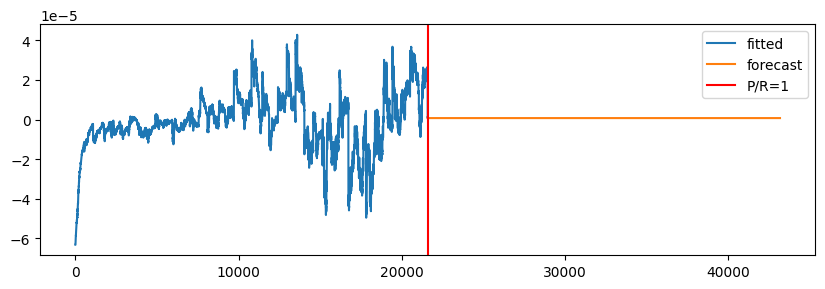

In [434]:
ses_1_object = SimpleExpSmoothing(train_1_euro_ret_s, 
                                initialization_method="legacy-heuristic")  # "legacy-heu" para definir cómo iniciar segun el primer valor
ses_1_model = ses_1_object.fit()
euro_1_df.loc[train_1_euro_idx, "SES"] = ses_1_model.fittedvalues
euro_1_df.loc[test_1_euro_idx, "SES"] = ses_1_model.forecast(ntest1)

fig, ax = plt.subplots(figsize=(10,3))
#ax.plot(euro_1_df["log_return"].index, euro_1_df["log_return"], label="data")
ax.plot(train_1_euro_ret_s.index, ses_1_model.fittedvalues, label="fitted")
ax.plot(test_1_euro_ret_s.index, ses_1_model.forecast(ntest1), label="forecast")
plt.axvline(len(euro_df)-ntest1, label="P/R=1", color="red")
ax.legend()

ses_1_model.summary()

In [435]:
### P/R = 0.4

Dep. Variable:,log_return,No. Observations:,30843
Model:,SimpleExpSmoothing,SSE,0.003
Optimized:,True,AIC,-495139.881
Trend:,None,BIC,-495123.208
Seasonal:,None,AICC,-495139.880
Seasonal Periods:,None,Date:,"Wed, 07 Jun 2023"
Box-Cox:,False,Time:,15:18:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0028022,alpha,True
initial_level,-6.3262e-05,l.0,False


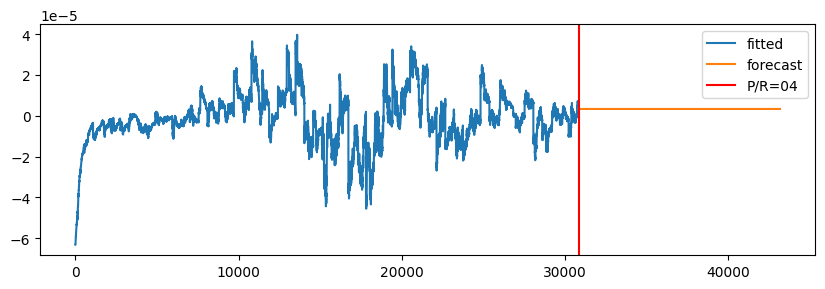

In [436]:
ses_04_object = SimpleExpSmoothing(train_04_euro_ret_s, 
                                initialization_method="legacy-heuristic")  # "legacy-heu" para definir cómo iniciar segun el primer valor
ses_04_model = ses_04_object.fit()
euro_04_df.loc[train_04_euro_idx, "SES"] = ses_04_model.fittedvalues
euro_04_df.loc[test_04_euro_idx, "SES"] = ses_04_model.forecast(ntest04)

fig, ax = plt.subplots(figsize=(10,3))
#ax.plot(euro_04_df["log_return"].index, euro_04_df["log_return"], label="data")
ax.plot(train_04_euro_ret_s.index, ses_04_model.fittedvalues, label="fitted")
ax.plot(test_04_euro_ret_s.index, ses_04_model.forecast(ntest04), label="forecast")
plt.axvline(len(euro_df)-ntest04, label="P/R=04", color="red")
ax.legend()

ses_04_model.summary()

## Holt Linear Trend

In [437]:
### P/R = 2

Dep. Variable:,log_return,No. Observations:,14394
Model:,Holt,SSE,0.001
Optimized:,True,AIC,-238617.197
Trend:,Additive,BIC,-238586.899
Seasonal:,None,AICC,-238617.191
Seasonal Periods:,None,Date:,"Wed, 07 Jun 2023"
Box-Cox:,False,Time:,15:18:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0757143,alpha,True
smoothing_trend,0.0344156,beta,True


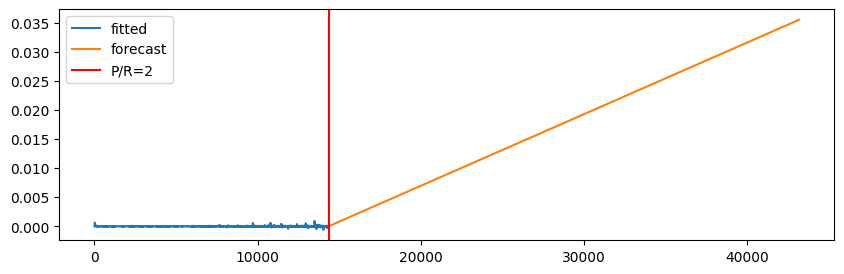

In [438]:
holt_trend_2_object = Holt(train_2_euro_ret_s, 
                         initialization_method="legacy-heuristic")
holt_trend_2_model = holt_trend_2_object.fit()
euro_2_df.loc[train_2_euro_idx, "Holt Lineal"] = holt_trend_2_model.fittedvalues
euro_2_df.loc[test_2_euro_idx, "Holt Lineal"] = holt_trend_2_model.forecast(ntest2)

fig, ax = plt.subplots(figsize=(10,3))
#ax.plot(euro_2_df["log_return"].index, euro_2_df["log_return"], label="data")
ax.plot(train_2_euro_ret_s.index, holt_trend_2_model.fittedvalues, label="fitted")
ax.plot(test_2_euro_ret_s.index, holt_trend_2_model.forecast(ntest2), label="forecast")
plt.axvline(len(euro_df)-ntest2, label="P/R=2", color="red")
ax.legend()

holt_trend_2_model.summary()

In [439]:
### P/R = 1

Dep. Variable:,log_return,No. Observations:,21590
Model:,Holt,SSE,0.003
Optimized:,True,AIC,-342867.876
Trend:,Additive,BIC,-342835.957
Seasonal:,None,AICC,-342867.873
Seasonal Periods:,None,Date:,"Wed, 07 Jun 2023"
Box-Cox:,False,Time:,15:18:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0521429,alpha,True
smoothing_trend,0.0289683,beta,True


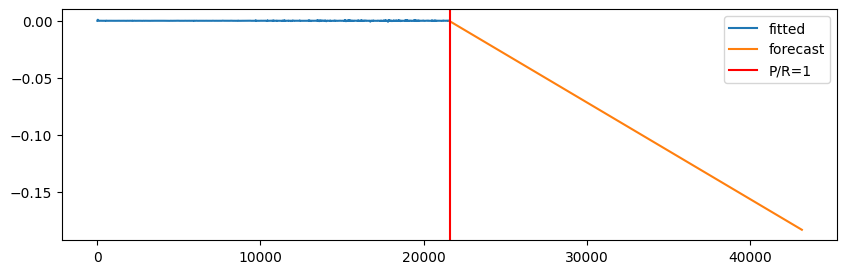

In [440]:
holt_trend_1_object = Holt(train_1_euro_ret_s, 
                         initialization_method="legacy-heuristic")
holt_trend_1_model = holt_trend_1_object.fit()
euro_1_df.loc[train_1_euro_idx, "Holt Lineal"] = holt_trend_1_model.fittedvalues
euro_1_df.loc[test_1_euro_idx, "Holt Lineal"] = holt_trend_1_model.forecast(ntest1)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(euro_1_df["log_return"].index, euro_1_df["log_return"], label="data")
ax.plot(train_1_euro_ret_s.index, holt_trend_1_model.fittedvalues, label="fitted")
ax.plot(test_1_euro_ret_s.index, holt_trend_1_model.forecast(ntest1), label="forecast")
plt.axvline(len(euro_df)-ntest1, label="P/R=1", color="red")
ax.legend()

holt_trend_1_model.summary()

In [441]:
### P/R = 0.4

Dep. Variable:,log_return,No. Observations:,30843
Model:,Holt,SSE,0.003
Optimized:,True,AIC,-493576.936
Trend:,Additive,BIC,-493543.590
Seasonal:,None,AICC,-493576.934
Seasonal Periods:,None,Date:,"Thu, 08 Jun 2023"
Box-Cox:,False,Time:,10:41:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0521429,alpha,True
smoothing_trend,0.0231746,beta,True


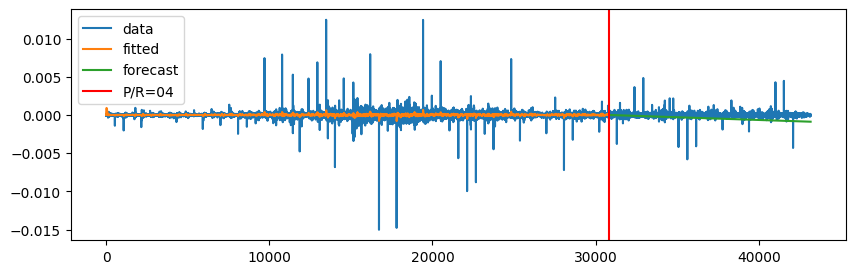

In [21]:
holt_trend_04_object = Holt(train_04_euro_ret_s, 
                         initialization_method="legacy-heuristic")
holt_trend_04_model = holt_trend_04_object.fit()
euro_04_df.loc[train_04_euro_idx, "Holt Lineal"] = holt_trend_04_model.fittedvalues
euro_04_df.loc[test_04_euro_idx, "Holt Lineal"] = holt_trend_04_model.forecast(ntest04)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(euro_04_df["log_return"].index, euro_04_df["log_return"], label="data")
ax.plot(train_04_euro_ret_s.index, holt_trend_04_model.fittedvalues, label="fitted")
ax.plot(test_04_euro_ret_s.index, holt_trend_04_model.forecast(ntest04), label="forecast")
plt.axvline(len(euro_df)-ntest04, label="P/R=04", color="red")
ax.legend()

holt_trend_04_model.summary()

## Holt - Winters

In [443]:
### P/R = 2

-235927.46318885873

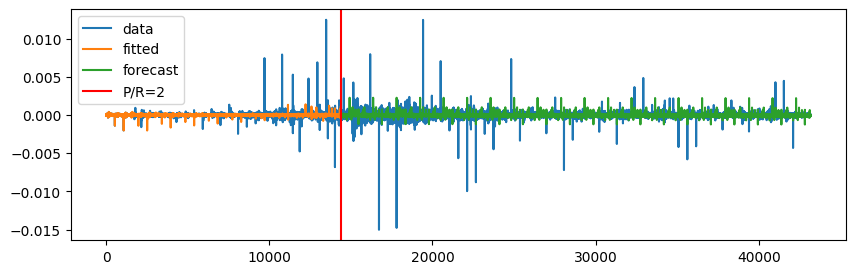

In [20]:
holt_winters_2_object = ExponentialSmoothing(train_2_euro_ret_s, trend="add",
                                             seasonal="add", seasonal_periods=1440,
                                             initialization_method="legacy-heuristic")
holt_winters_2_model = holt_winters_2_object.fit()
euro_2_df.loc[train_2_euro_idx, "Holt Winters"] = holt_winters_2_model.fittedvalues
euro_2_df.loc[test_2_euro_idx, "Holt Winters"] = holt_winters_2_model.forecast(ntest2)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(euro_2_df["log_return"].index, euro_2_df["log_return"], label="data")
ax.plot(train_2_euro_ret_s.index, holt_winters_2_model.fittedvalues, label="fitted")
ax.plot(test_2_euro_ret_s.index, holt_winters_2_model.forecast(ntest2), label="forecast")
plt.axvline(len(euro_df)-ntest2, label="P/R=2", color="red")
ax.legend()

In [445]:
### P/R = 1

Dep. Variable:,log_return,No. Observations:,21590
Model:,ExponentialSmoothing,SSE,0.003
Optimized:,True,AIC,-343410.665
Trend:,Additive,BIC,-343346.825
Seasonal:,Additive,AICC,-343410.655
Seasonal Periods:,4,Date:,"Wed, 07 Jun 2023"
Box-Cox:,False,Time:,15:18:50
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0290055,alpha,True
smoothing_trend,0.0058248,beta,True


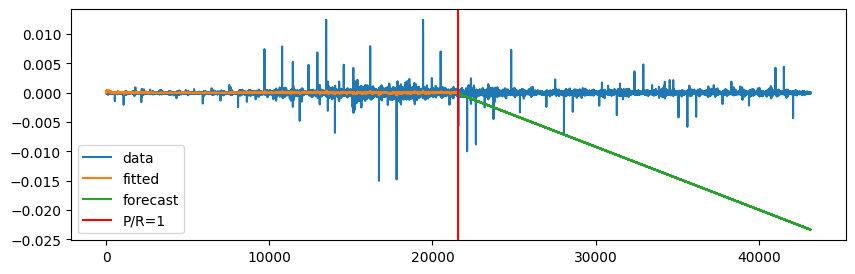

In [446]:
holt_winters_1_object = ExponentialSmoothing(train_1_euro_ret_s, trend="add",
                                             seasonal="add", seasonal_periods=4,
                                             initialization_method="legacy-heuristic")
holt_winters_1_model = holt_winters_1_object.fit()
euro_1_df.loc[train_1_euro_idx, "Holt Winters"] = holt_winters_1_model.fittedvalues
euro_1_df.loc[test_1_euro_idx, "Holt Winters"] = holt_winters_1_model.forecast(ntest1)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(euro_1_df["log_return"].index, euro_1_df["log_return"], label="data")
ax.plot(train_1_euro_ret_s.index, holt_winters_1_model.fittedvalues, label="fitted")
ax.plot(test_1_euro_ret_s.index, holt_winters_1_model.forecast(ntest1), label="forecast")
plt.axvline(len(euro_df)-ntest1, label="P/R=1", color="red")
ax.legend()

holt_winters_1_model.summary()

In [447]:
### P/R = 0.4

Dep. Variable:,log_return,No. Observations:,30843
Model:,ExponentialSmoothing,SSE,0.003
Optimized:,True,AIC,-494308.020
Trend:,Additive,BIC,-494241.327
Seasonal:,Additive,AICC,-494308.013
Seasonal Periods:,4,Date:,"Wed, 07 Jun 2023"
Box-Cox:,False,Time:,15:18:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0252923,alpha,True
smoothing_trend,0.0050728,beta,True


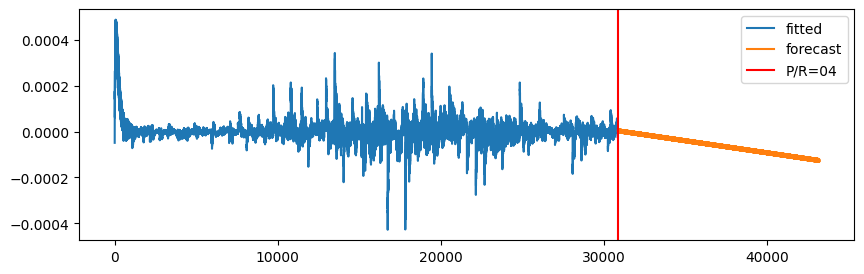

In [448]:
holt_winters_04_object = ExponentialSmoothing(train_04_euro_ret_s, trend="add",
                                             seasonal="add", seasonal_periods=4,
                                             initialization_method="legacy-heuristic")
holt_winters_04_model = holt_winters_04_object.fit()
euro_04_df.loc[train_04_euro_idx, "Holt Winters"] = holt_winters_04_model.fittedvalues
euro_04_df.loc[test_04_euro_idx, "Holt Winters"] = holt_winters_04_model.forecast(ntest04)

fig, ax = plt.subplots(figsize=(10,3))
#ax.plot(euro_04_df["log_return"].index, euro_04_df["log_return"], label="data")
ax.plot(train_04_euro_ret_s.index, holt_winters_04_model.fittedvalues, label="fitted")
ax.plot(test_04_euro_ret_s.index, holt_winters_04_model.forecast(ntest04), label="forecast")
plt.axvline(len(euro_df)-ntest04, label="P/R=04", color="red")
ax.legend()

holt_winters_04_model.summary()

In [449]:
holt_price = ExponentialSmoothing(train_price_04_s, trend="add", seasonal="mul", 
                                  seasonal_periods=20000, initialization_method="legacy-heuristic")
holt_price = holt_price.fit()
holt_price.forecast(ntest04)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(price_close_s.index, price_close_s, label="data")
ax.plot(train_price_04_s.index, holt_price.fittedvalues, label="fitted")
ax.plot(test_price_04_s.index, holt_price.forecast(ntest04), label="forecast")
plt.axvline(len(euro_df)-ntest04, label="P/R=2", color="red")
ax.legend();

#holt_price.summary()

ValueError: operands could not be broadcast together with shapes (10844,) (20000,) 

## Resumen

In [ ]:
p_r = 2
aic_expsmoothing_2_ls = [ses_2_model.aic, holt_trend_2_model.aic, holt_winters_2_model.aic]
bic_expsmoothing_2_ls = [ses_2_model.bic, holt_trend_2_model.bic, holt_winters_2_model.bic]
names_df= pd.DataFrame(["MSE", "MSFE", "R^2 IS", "R^2 OOS", "AIC IS", "BIC IS"])
pr_2_df = pd.DataFrame([p_r, p_r, p_r, p_r, p_r, p_r]).rename(columns={0:"P/R"})



msfe_expsmoothing_2_ls = []
mse_expsmoothing_2_ls = []
r2_expsmoothing_2_fit_ls = []
r2_expsmoothing_2_oos_ls = []
for x in range(6, 9):
    msfe = np.sqrt(mean_squared_error(euro_2_df.loc[test_2_euro_idx, "log_return"], euro_2_df.iloc[test_2_euro_idx, x]))
    msfe_expsmoothing_2_ls.append(msfe)
    mse = np.sqrt(mean_squared_error(euro_2_df.loc[train_2_euro_idx, "log_return"], euro_2_df.iloc[train_2_euro_idx, x]))
    mse_expsmoothing_2_ls.append(mse)
    r2_fit = r2_score(euro_2_df.loc[train_2_euro_idx, "log_return"], euro_2_df.iloc[train_2_euro_idx, x])
    r2_expsmoothing_2_fit_ls.append(r2_fit)
    r2_oos = r2_score(euro_2_df.loc[test_2_euro_idx, "log_return"], euro_2_df.iloc[test_2_euro_idx, x])
    r2_expsmoothing_2_oos_ls.append(r2_oos)
    
resumen_expsmoothing_2_df = pd.concat([pd.DataFrame(mse_expsmoothing_2_ls, index=euro_2_df.columns[6:9]),
                          pd.DataFrame(msfe_expsmoothing_2_ls, index=euro_2_df.columns[6:9]),
                          pd.DataFrame(r2_expsmoothing_2_fit_ls, index=euro_2_df.columns[6:9]),
                          pd.DataFrame(r2_expsmoothing_2_oos_ls, index=euro_2_df.columns[6:9]),
                          pd.DataFrame(aic_expsmoothing_2_ls, index=euro_2_df.columns[6:9]),
                          pd.DataFrame(bic_expsmoothing_2_ls, index=euro_2_df.columns[6:9])], 
                          axis=1).T.reset_index(drop=True)

resumen_expsmoothing_2_df = pd.concat([names_df, pr_2_df, resumen_expsmoothing_2_df], axis=1).set_index(0).rename_axis("Metrica")
resumen_expsmoothing_2_df

In [ ]:
p_r = 1
aic_expsmoothing_1_ls = [ses_1_model.aic, holt_trend_1_model.aic, holt_winters_1_model.aic]
bic_expsmoothing_1_ls = [ses_1_model.bic, holt_trend_1_model.bic, holt_winters_1_model.bic]
names_df= pd.DataFrame(["MSE", "MSFE", "R^2 IS", "R^2 OOS", "AIC IS", "BIC IS"])
pr_1_df = pd.DataFrame([p_r, p_r, p_r, p_r, p_r, p_r]).rename(columns={0:"P/R"})

msfe_expsmoothing_1_ls = []
mse_expsmoothing_1_ls = []
r2_expsmoothing_1_fit_ls = []
r2_expsmoothing_1_oos_ls = []
for x in range(6, 9):
    msfe = np.sqrt(((euro_1_df.loc[test_1_euro_idx, "log_return"] - euro_1_df.iloc[test_1_euro_idx, x]).mean())**2)
    msfe_expsmoothing_1_ls.append(msfe)
    mse = np.sqrt(((euro_1_df.loc[train_1_euro_idx, "log_return"] - euro_1_df.iloc[train_1_euro_idx, x]).mean())**2)
    mse_expsmoothing_1_ls.append(mse)
    r2_fit = r2_score(euro_1_df.loc[train_1_euro_idx, "log_return"], euro_1_df.iloc[train_1_euro_idx, x])
    r2_expsmoothing_1_fit_ls.append(r2_fit)
    r2_oos = r2_score(euro_1_df.loc[test_1_euro_idx, "log_return"], euro_1_df.iloc[test_1_euro_idx, x])
    r2_expsmoothing_1_oos_ls.append(r2_oos)
    
resumen_expsmoothing_1_df = pd.concat([pd.DataFrame(mse_expsmoothing_1_ls, index=euro_1_df.columns[6:9]),
                          pd.DataFrame(msfe_expsmoothing_1_ls, index=euro_1_df.columns[6:9]),
                          pd.DataFrame(r2_expsmoothing_1_fit_ls, index=euro_1_df.columns[6:9]),
                          pd.DataFrame(r2_expsmoothing_1_oos_ls, index=euro_1_df.columns[6:9]),
                          pd.DataFrame(aic_expsmoothing_1_ls, index=euro_1_df.columns[6:9]),
                          pd.DataFrame(bic_expsmoothing_1_ls, index=euro_1_df.columns[6:9])], 
                          axis=1).T.reset_index(drop=True)

resumen_expsmoothing_1_df = pd.concat([names_df, pr_1_df, resumen_expsmoothing_1_df], axis=1).set_index(0).rename_axis("Metrica")
resumen_expsmoothing_1_df

In [ ]:
p_r = 0.4
aic_expsmoothing_04_ls = [ses_04_model.aic, holt_trend_04_model.aic, holt_winters_04_model.aic]
bic_expsmoothing_04_ls = [ses_04_model.bic, holt_trend_04_model.bic, holt_winters_04_model.bic]
names_df= pd.DataFrame(["MSE", "MSFE", "R^2 IS", "R^2 OOS", "AIC IS", "BIC IS"])
pr_04_df = pd.DataFrame([p_r, p_r, p_r, p_r, p_r, p_r]).rename(columns={0:"P/R"})

msfe_expsmoothing_04_ls = []
mse_expsmoothing_04_ls = []
r2_expsmoothing_04_fit_ls = []
r2_expsmoothing_04_oos_ls = []
for x in range(6, 9):
    msfe = np.sqrt(((euro_04_df.loc[test_04_euro_idx, "log_return"] - euro_04_df.iloc[test_04_euro_idx, x]).mean())**2)
    msfe_expsmoothing_04_ls.append(msfe)
    mse = np.sqrt(((euro_04_df.loc[train_04_euro_idx, "log_return"] - euro_04_df.iloc[train_04_euro_idx, x]).mean())**2)
    mse_expsmoothing_04_ls.append(mse)
    r2_fit = r2_score(euro_04_df.loc[train_04_euro_idx, "log_return"], euro_04_df.iloc[train_04_euro_idx, x])
    r2_expsmoothing_04_fit_ls.append(r2_fit)
    r2_oos = r2_score(euro_04_df.loc[test_04_euro_idx, "log_return"], euro_04_df.iloc[test_04_euro_idx, x])
    r2_expsmoothing_04_oos_ls.append(r2_oos)

resumen_expsmoothing_04_df = pd.concat([pd.DataFrame(mse_expsmoothing_04_ls, index=euro_04_df.columns[6:9]),
                          pd.DataFrame(msfe_expsmoothing_04_ls, index=euro_04_df.columns[6:9]),
                          pd.DataFrame(r2_expsmoothing_04_fit_ls, index=euro_04_df.columns[6:9]),
                          pd.DataFrame(r2_expsmoothing_04_oos_ls, index=euro_04_df.columns[6:9]),
                          pd.DataFrame(aic_expsmoothing_04_ls, index=euro_04_df.columns[6:9]),
                          pd.DataFrame(bic_expsmoothing_04_ls, index=euro_04_df.columns[6:9])], 
                          axis=1).T.reset_index(drop=True)

resumen_expsmoothing_04_df = pd.concat([names_df,  pr_04_df, resumen_expsmoothing_04_df], axis=1).set_index(0).rename_axis("Metrica")
resumen_expsmoothing_04_df

In [ ]:
resumen_expsmoothing_df = pd.concat([resumen_expsmoothing_2_df, resumen_expsmoothing_1_df, resumen_expsmoothing_04_df], axis=0)
resumen_expsmoothing_df.reset_index().set_index(["P/R", "Metrica"])
resumen_expsmoothing_df.reset_index().set_index(["Metrica", "P/R"])
resumen_expsmoothing_df.reset_index().set_index(["P/R", "Metrica"])

pd.concat([resumen_expsmoothing_2_df, resumen_expsmoothing_1_df, resumen_expsmoothing_04_df], axis=0).reset_index().set_index(["Metrica"])
resumen_expsmoothing_df.reset_index().set_index(["P/R", "Metrica"])

In [ ]:
euro_2_df

# Arima

### P/R = 2

In [453]:
arima_2_scaled_euro_ret = ARIMA(train_2_scaled_euro_ret_s, order=(1,0,1))
arima_2_scaled_euro_ret_results = arima_2_scaled_euro_ret.fit()
arima_2_scaled_euro_ret_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                14394
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -20418.902
Date:                Wed, 07 Jun 2023   AIC                          40845.804
Time:                        15:19:14   BIC                          40876.102
Sample:                             0   HQIC                         40855.877
                              - 14394                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.251e-06      0.010     -0.001      1.000      -0.019       0.019
ar.L1          0.0265      0.261      0.102      0.919      -0.484       0.537
ma.L1         -0.0523      0.260     -0.201      0.841      -0.562       0.457
sigma2         0.9990      0.001   1398.659      0.000       0.998       1.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         342967848.24
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              16.77   Skew:                            14.16
Prob(H) (two-sided):                  0.00   Kurtosis:                       758.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [454]:
#### Escalado

In [480]:
# Buscar hiperparametros

model_arima_2_scaled_euro = pm.auto_arima(train_2_scaled_euro_ret_s, maxiter=15, n_jobs=2)
arima_parameters_2_scaled_euro_ls = model_arima_2_scaled_euro.get_params()["order"]

/Users/leonplaza/Desktop/Repositorio GITHUB/messiaen/venv/lib/python3.11/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                14394
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -20421.611
Date:                Wed, 07 Jun 2023   AIC                          40851.222
Time:                        15:45:59   BIC                          40881.520
Sample:                             0   HQIC                         40861.295
                              - 14394                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0261      0.004     -7.197      0.000      -0.033      -0.019
ar.L2         -0.0013      0.007     -0.192      0.848      -0.014       0.012
ma.L1         -0.9997      0.000  -5292.835      0.000      -1.000      -0.999
sigma2         0.9993      0.001   1507.128      0.000       0.998       1.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         341977475.00
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              16.83   Skew:                            14.10
Prob(H) (two-sided):                  0.00   Kurtosis:                       757.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

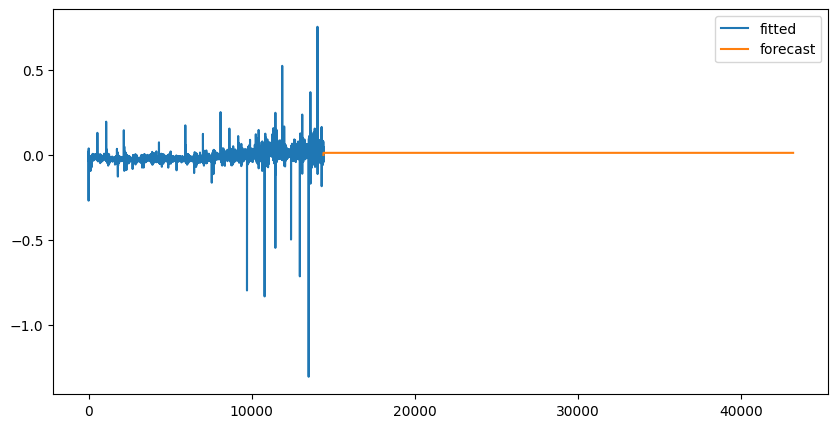

In [481]:
arima_2_scaled_euro_ret = ARIMA(train_2_scaled_euro_ret_s, order=arima_parameters_2_scaled_euro_ls) 
arima_2_scaled_euro_ret_results = arima_2_scaled_euro_ret.fit()
arima_2_scaled_euro_ret_results.predict(start=0, end=-1)

euro_2_df.loc[train_2_euro_idx, "ARIMA Scaled"] = arima_2_scaled_euro_ret_results.predict(start=0, end=-1)
euro_2_df.loc[test_2_euro_idx, "ARIMA Scaled"] = arima_2_scaled_euro_ret_results.get_forecast(ntest2).predicted_mean

fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(euro_2_df["Scaled 2"].index, euro_2_df["Scaled 2"], label="data")
ax.plot(train_2_scaled_euro_ret_s.index, arima_2_scaled_euro_ret_results.predict(start=0, end=-1), label="fitted")
ax.plot(test_2_scaled_euro_ret_s.index, arima_2_scaled_euro_ret_results.get_forecast(ntest2).predicted_mean, label="forecast")
ax.legend()

arima_2_scaled_euro_ret_results.

In [457]:
#### No escalado

In [458]:
len(euro_2_df) - ntest2

14394

In [459]:
# Buscar hiperparametros
model_arima_2_euro = pm.auto_arima(train_2_euro_ret_s, maxiter=1)
arima_parameters_2_euro_ls = model_arima_2_euro.get_params()["order"]

In [460]:
euro_2_df.iloc[(len(euro_2_df) - ntest2-10):14400,9]
arima_2_euro_ret_results.get_forecast(ntest2).predicted_mean

14394    0.000068
14395    0.000057
14396    0.000062
14397    0.000050
14398    0.000049
           ...   
43175    0.000049
43176    0.000049
43177    0.000049
43178    0.000049
43179    0.000049
Name: predicted_mean, Length: 28786, dtype: float64

/Users/leonplaza/Desktop/Repositorio GITHUB/messiaen/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                14394
Model:                 ARIMA(0, 1, 5)   Log Likelihood               99013.095
Date:                Wed, 07 Jun 2023   AIC                        -198014.191
Time:                        15:20:57   BIC                        -197968.744
Sample:                             0   HQIC                       -197999.081
                              - 14394                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9450    1.6e-18  -5.92e+17      0.000      -0.945      -0.945
ma.L2          0.0179   1.55e-18   1.16e+16      0.000       0.018       0.018
ma.L3         -0.0206    1.5e-18  -1.37e+16      0.000      -0.021      -0.021
ma.L4         -0.0113    1.5e-18  -7.54e+15      0.000      -0.011      -0.011
ma.L5         -0.0258   1.43e-18  -1.81e+16      0.000      -0.026      -0.026
sigma2      5.747e-08   3.59e-11   1602.539      0.000    5.74e-08    5.75e-08
===================================================================================
Ljung-Box (L1) (Q):                 105.54   Jarque-Bera (JB):         284989842.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              16.87   Skew:                            13.30
Prob(H) (two-sided):                  0.00   Kurtosis:                       691.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.87e+31. Standard errors may be unstable.
"""

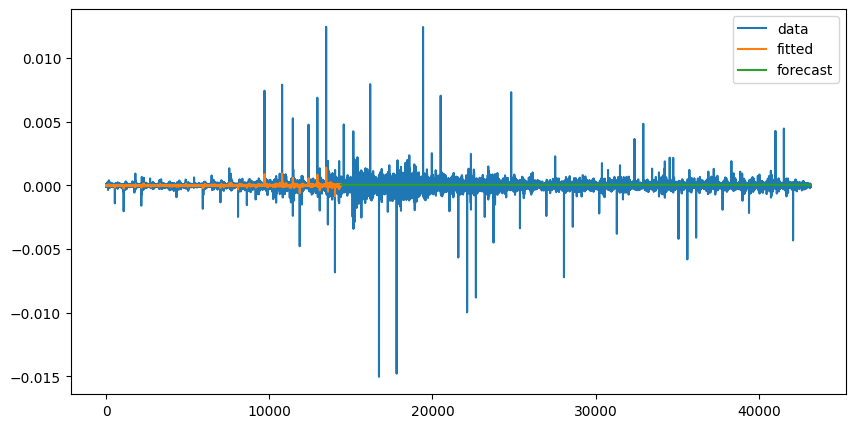

In [461]:
arima_2_euro_ret = ARIMA(train_2_euro_ret_s, order=arima_parameters_2_euro_ls) 
arima_2_euro_ret_results = arima_2_euro_ret.fit()
arima_2_euro_ret_results.predict(start=0, end=-1)

euro_2_df.loc[train_2_euro_idx, "ARIMA"] = arima_2_euro_ret_results.predict(start=0, end=-1)
euro_2_df.loc[test_2_euro_idx, "ARIMA"] = arima_2_euro_ret_results.get_forecast(ntest2).predicted_mean

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(euro_2_df["log_return"].index, euro_2_df["log_return"], label="data")
ax.plot(train_2_euro_ret_s.index, arima_2_euro_ret_results.predict(start=0, end=-1), label="fitted")
ax.plot(test_2_euro_ret_s.index, arima_2_euro_ret_results.get_forecast(ntest2).predicted_mean, label="forecast")
ax.legend()

arima_2_euro_ret_results.summary()

### P/R = 1

In [462]:
#### Escalado

In [463]:
arima_1_scaled_euro_ret = ARIMA(train_1_scaled_euro_ret_s, order=(1,0,5)) 
arima_1_scaled_euro_ret_results = arima_1_scaled_euro_ret.fit()
arima_1_scaled_euro_ret_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                21590
Model:                 ARIMA(1, 0, 5)   Log Likelihood              -30628.322
Date:                Wed, 07 Jun 2023   AIC                          61272.644
Time:                        15:21:25   BIC                          61336.484
Sample:                             0   HQIC                         61293.453
                              - 21590                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.563e-05      0.006      0.009      0.993      -0.013       0.013
ar.L1          0.7989      0.088      9.048      0.000       0.626       0.972
ma.L1         -0.8061      0.089     -9.101      0.000      -0.980      -0.632
ma.L2          0.0006      0.006      0.094      0.925      -0.012       0.013
ma.L3          0.0067      0.006      1.093      0.274      -0.005       0.019
ma.L4         -0.0045      0.006     -0.763      0.445      -0.016       0.007
ma.L5         -0.0113      0.006     -2.035      0.042      -0.022      -0.000
sigma2         0.9994      0.001   1583.019      0.000       0.998       1.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         264400138.82
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              26.06   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       545.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [464]:
# Buscar hiperparametros

model_arima_1_scaled_euro = pm.auto_arima(train_1_scaled_euro_ret_s, maxiter=1)
arima_parameters_1_scaled_euro_ls = model_arima_1_scaled_euro.get_params()["order"]

In [465]:
arima_1_scaled_euro_ret = ARIMA(train_1_scaled_euro_ret_s, order=arima_parameters_1_scaled_euro_ls) 
arima_1_scaled_euro_ret_results = arima_1_scaled_euro_ret.fit()
arima_1_scaled_euro_ret_results.predict(start=0, end=-1)

euro_1_df.loc[train_1_euro_idx, "ARIMA Scaled"] = arima_1_scaled_euro_ret_results.predict(start=0, end=-1)
euro_1_df.loc[test_1_euro_idx, "ARIMA Scaled"] = arima_1_scaled_euro_ret_results.get_forecast(ntest1).predicted_mean

#fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(euro_1_df["Scaled 2"].index, euro_1_df["Scaled 2"], label="data")
# ax.plot(train_1_scaled_euro_ret_s.index, arima_1_scaled_euro_ret_results.predict(start=0, end=-1), label="fitted")
# ax.plot(test_1_scaled_euro_ret_s.index, arima_1_scaled_euro_ret_results.get_forecast(ntest1).predicted_mean, label="forecast")
# ax.legend()

arima_1_scaled_euro_ret_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                21590
Model:                          ARIMA   Log Likelihood              -30634.383
Date:                Wed, 07 Jun 2023   AIC                          61272.766
Time:                        15:21:34   BIC                          61288.726
Sample:                             0   HQIC                         61277.968
                              - 21590                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.998e-06      0.007     -0.001      0.999      -0.013       0.013
sigma2         1.0000      0.001   1711.617      0.000       0.999       1.001
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):         264281789.54
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):              26.09   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       545.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                21590
Model:                          ARIMA   Log Likelihood              -30634.383
Date:                Wed, 07 Jun 2023   AIC                          61272.766
Time:                        15:21:43   BIC                          61288.726
Sample:                             0   HQIC                         61277.968
                              - 21590                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.998e-06      0.007     -0.001      0.999      -0.013       0.013
sigma2         1.0000      0.001   1711.617      0.000       0.999       1.001
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):         264281789.54
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):              26.09   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       545.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

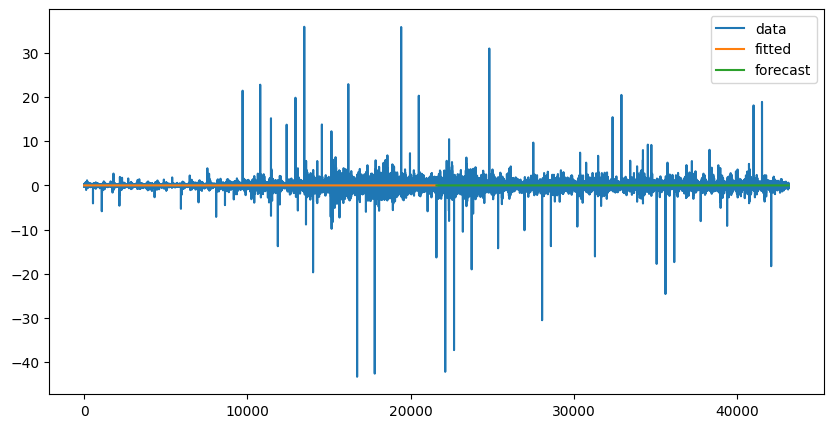

In [466]:
# Buscar hiperparametros
model_arima_1_scaled_euro = pm.auto_arima(train_1_scaled_euro_ret_s, maxiter=1)
arima_parameters_1_scaled_euro_ls = model_arima_1_scaled_euro.get_params()["order"]

arima_1_scaled_euro_ret = ARIMA(train_1_scaled_euro_ret_s, order=arima_parameters_1_scaled_euro_ls) 
arima_1_scaled_euro_ret_results = arima_1_scaled_euro_ret.fit()
arima_1_scaled_euro_ret_results.predict(start=0, end=-1)

euro_1_df.loc[train_1_euro_idx, "ARIMA Scaled"] = arima_1_scaled_euro_ret_results.predict(start=0, end=-1)
euro_1_df.loc[test_1_euro_idx, "ARIMA Scaled"] = arima_1_scaled_euro_ret_results.get_forecast(ntest1).predicted_mean

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(euro_1_df["Scaled 1"].index, euro_1_df["Scaled 1"], label="data")
ax.plot(train_1_scaled_euro_ret_s.index, arima_1_scaled_euro_ret_results.predict(start=0, end=-1), label="fitted")
ax.plot(test_1_scaled_euro_ret_s.index, arima_1_scaled_euro_ret_results.get_forecast(ntest1).predicted_mean, label="forecast")
ax.legend()

arima_1_scaled_euro_ret_results.summary()

In [467]:
#### No Escalado

In [468]:
arima_1_euro_ret = ARIMA(train_1_euro_ret_s, order=(2,0,1))
arima_1_euro_ret_results = arima_1_euro_ret.fit()
arima_1_euro_ret_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                21590
Model:                 ARIMA(2, 0, 1)   Log Likelihood              141391.963
Date:                Wed, 07 Jun 2023   AIC                        -282773.925
Time:                        15:21:46   BIC                        -282734.025
Sample:                             0   HQIC                       -282760.920
                              - 21590                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.069e-09   2.34e-06     -0.002      0.998   -4.59e-06    4.58e-06
ar.L1         -0.6172   1.75e-10  -3.53e+09      0.000      -0.617      -0.617
ar.L2         -0.0090   4.98e-11  -1.81e+08      0.000      -0.009      -0.009
ma.L1          0.6103   1.74e-10   3.52e+09      0.000       0.610       0.610
sigma2        1.2e-07   7.01e-11   1711.592      0.000     1.2e-07     1.2e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         264396125.34
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              26.09   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       545.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.77e+25. Standard errors may be unstable.
"""

In [469]:
# Buscar hiperparametros
model_arima_1_euro = pm.auto_arima(train_1_euro_ret_s, maxiter=1)
arima_parameters_1_euro_ls = model_arima_1_euro.get_params()["order"]

/Users/leonplaza/Desktop/Repositorio GITHUB/messiaen/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                21590
Model:                          ARIMA   Log Likelihood              141389.251
Date:                Wed, 07 Jun 2023   AIC                        -282774.502
Time:                        15:22:07   BIC                        -282758.542
Sample:                             0   HQIC                       -282769.300
                              - 21590                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.97e-06   2.36e-06     -2.106      0.035    -9.6e-06   -3.45e-07
sigma2        1.2e-07   7.01e-11   1711.357      0.000     1.2e-07     1.2e-07
===================================================================================
Ljung-Box (L1) (Q):                   1.01   Jarque-Bera (JB):         264281789.54
Prob(Q):                              0.32   Prob(JB):                         0.00
Heteroskedasticity (H):              26.12   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                       545.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

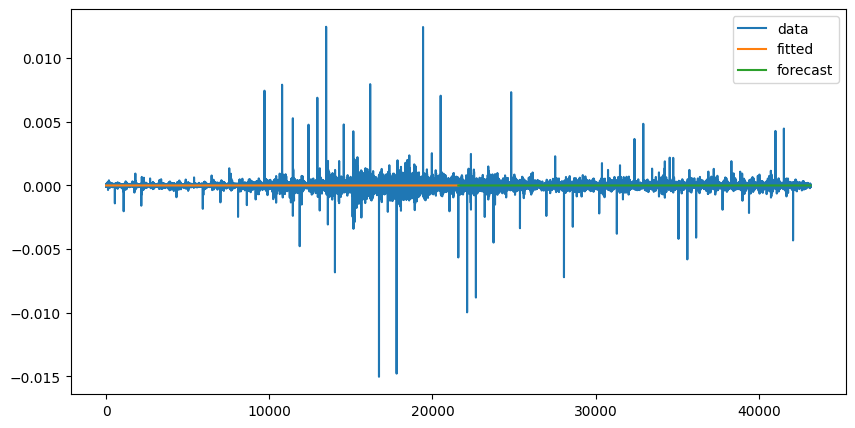

In [470]:
arima_1_euro_ret = ARIMA(train_1_euro_ret_s, order=arima_parameters_1_euro_ls) 
arima_1_euro_ret_results = arima_1_euro_ret.fit()
arima_1_euro_ret_results.predict(start=0, end=-1)

euro_1_df.loc[train_1_euro_idx, "ARIMA"] = arima_1_euro_ret_results.predict(start=0, end=-1)
euro_1_df.loc[test_1_euro_idx, "ARIMA"] = arima_1_euro_ret_results.get_forecast(ntest1).predicted_mean

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(euro_1_df["log_return"].index, euro_1_df["log_return"], label="data")
ax.plot(train_1_euro_ret_s.index, arima_1_euro_ret_results.predict(start=0, end=-1), label="fitted")
ax.plot(test_1_euro_ret_s.index, arima_1_euro_ret_results.get_forecast(ntest1).predicted_mean, label="forecast")
ax.legend()

arima_1_euro_ret_results.summary()

### P/R = 0.4

In [471]:
#### Escalado

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                30843
Model:                          ARIMA   Log Likelihood              -43763.821
Date:                Wed, 07 Jun 2023   AIC                          87531.642
Time:                        15:22:16   BIC                          87548.316
Sample:                             0   HQIC                         87536.985
                              - 30843                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.013e-06      0.006     -0.001      0.999      -0.011       0.011
sigma2         1.0000      0.000   2042.114      0.000       0.999       1.001
===================================================================================
Ljung-Box (L1) (Q):                   2.98   Jarque-Bera (JB):         382687963.64
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               4.30   Skew:                            -2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                       548.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

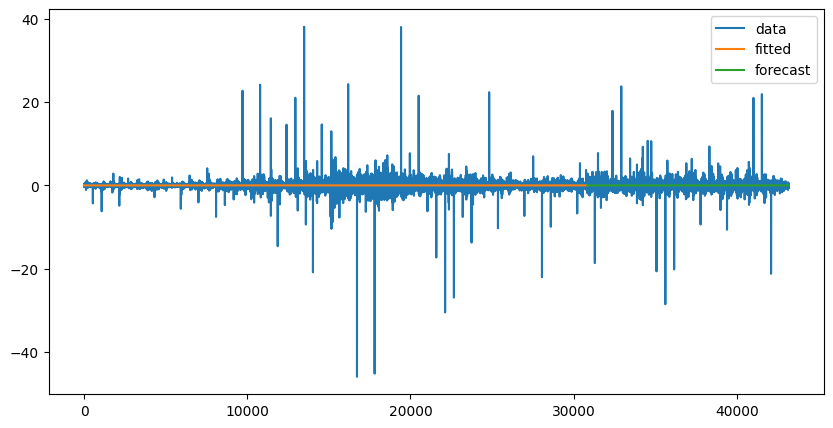

In [472]:
# Buscar hiperparametros
model_arima_04_scaled_euro = pm.auto_arima(train_04_scaled_euro_ret_s, maxiter=1)
arima_parameters_04_scaled_euro_ls = model_arima_04_scaled_euro.get_params()["order"]


arima_04_scaled_euro_ret = ARIMA(train_04_scaled_euro_ret_s, order=arima_parameters_04_scaled_euro_ls) 
arima_04_scaled_euro_ret_results = arima_04_scaled_euro_ret.fit()
arima_04_scaled_euro_ret_results.predict(start=0, end=-1)

euro_04_df.loc[train_04_euro_idx, "ARIMA Scaled"] = arima_04_scaled_euro_ret_results.predict(start=0, end=-1)
euro_04_df.loc[test_04_euro_idx, "ARIMA Scaled"] = arima_04_scaled_euro_ret_results.get_forecast(ntest04).predicted_mean

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(euro_04_df["Scaled 04"].index, euro_04_df["Scaled 04"], label="data")
ax.plot(train_04_scaled_euro_ret_s.index, arima_04_scaled_euro_ret_results.predict(start=0, end=-1), label="fitted")
ax.plot(test_04_scaled_euro_ret_s.index, arima_04_scaled_euro_ret_results.get_forecast(ntest04).predicted_mean, label="forecast")
ax.legend()

arima_04_scaled_euro_ret_results.summary()

In [473]:
#### No Escalado

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                30843
Model:                          ARIMA   Log Likelihood              203824.699
Date:                Wed, 07 Jun 2023   AIC                        -407645.397
Time:                        15:22:42   BIC                        -407628.724
Sample:                             0   HQIC                       -407640.055
                              - 30843                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.561e-06   1.81e-06     -3.066      0.002   -9.12e-06   -2.01e-06
sigma2      1.033e-07   4.91e-11   2103.976      0.000    1.03e-07    1.03e-07
===================================================================================
Ljung-Box (L1) (Q):                   2.98   Jarque-Bera (JB):         382687963.64
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               4.30   Skew:                            -2.62
Prob(H) (two-sided):                  0.00   Kurtosis:                       548.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

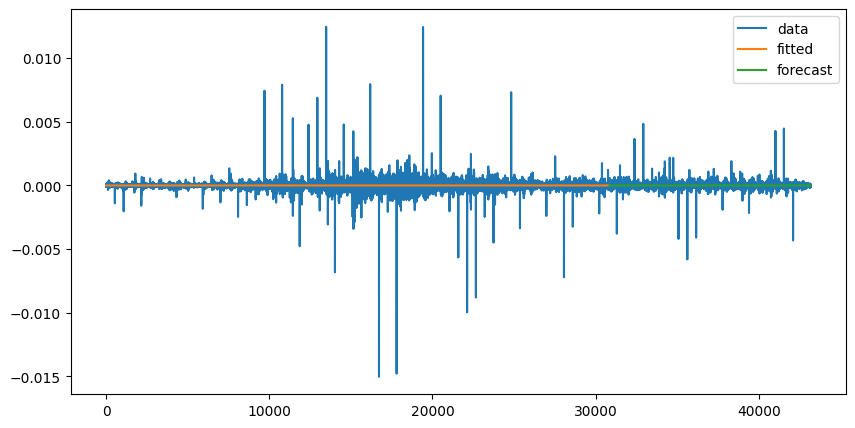

In [474]:
# Buscar hiperparametros
model_arima_04_euro = pm.auto_arima(train_04_euro_ret_s, maxiter=15)
arima_parameters_04_euro_ls = model_arima_04_euro.get_params()["order"]


arima_04_euro_ret = ARIMA(train_04_euro_ret_s, order=arima_parameters_04_euro_ls) 
arima_04_euro_ret_results = arima_04_euro_ret.fit()
arima_04_euro_ret_results.predict(start=0, end=-1)

euro_04_df.loc[train_04_euro_idx, "ARIMA"] = arima_04_euro_ret_results.predict(start=0, end=-1)
euro_04_df.loc[test_04_euro_idx, "ARIMA"] = arima_04_euro_ret_results.get_forecast(ntest04).predicted_mean

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(euro_04_df["log_return"].index, euro_04_df["log_return"], label="data")
ax.plot(train_04_euro_ret_s.index, arima_04_euro_ret_results.predict(start=0, end=-1), label="fitted")
ax.plot(test_04_euro_ret_s.index, arima_04_euro_ret_results.get_forecast(ntest04).predicted_mean, label="forecast")
ax.legend()

arima_04_euro_ret_results.summary()

## Resumen

In [475]:
euro_2_df

,datetime,log_return,Scaled 2,GBM,Random Walk,Naive Forecast,SES,Holt Lineal,Holt Winters,ARIMA Scaled,ARIMA
0,2020-02-03 09:01:00,-0.000063,-0.267918,0.000002,0.000002,NaN,-0.000063,0.000009,-0.000063,0.000000,0.000000
1,2020-02-03 09:02:00,0.000009,0.030584,0.000002,0.000002,-0.000063,-0.000063,0.000076,0.000009,-0.267918,-0.000063
2,2020-02-03 09:03:00,0.000081,0.329077,0.000002,0.000002,0.000009,-0.000063,0.000143,0.000081,-0.122361,-0.000028
3,2020-02-03 09:04:00,-0.000090,-0.379851,0.000002,0.000002,0.000081,-0.000062,0.000210,-0.000090,0.025429,0.000010
4,2020-02-03 09:05:00,0.000099,0.403701,0.000002,0.000002,-0.000090,-0.000062,0.000258,0.000099,-0.063641,-0.000014
...,...,...,...,...,...,...,...,...,...,...,...
43175,2020-05-25 17:55:00,0.000000,0.004220,0.000002,0.000002,0.000064,-0.000013,0.035484,-0.000380,0.001938,0.000049
43176,2020-05-25 17:56:00,0.000009,0.032895,0.000002,0.000002,0.000000,-0.000013,0.035485,0.000403,0.001938,0.000049
43177,2020-05-25 17:57:00,-0.000128,-0.397253,0.000002,0.000002,0.000009,-0.000013,0.035487,-0.000016,0.001938,0.000049
43178,2020-05-25 17:58:00,0.000000,0.004220,0.000002,0.000002,-0.000128,-0.000013,0.035488,-0.000145,0.001938,0.000049


In [477]:
# rmse

rmse_train_arima_ls = [np.sqrt(mean_squared_error(train_2_euro_ret_s, euro_2_df.loc[train_2_euro_idx, "ARIMA"])),
          np.sqrt(mean_squared_error(train_1_euro_ret_s, euro_1_df.loc[train_1_euro_idx, "ARIMA"])),
          np.sqrt(mean_squared_error(train_04_euro_ret_s, euro_04_df.loc[train_04_euro_idx, "ARIMA"]))]

rmse_train_arima_scaled_ls = [np.sqrt(mean_squared_error(train_2_scaled_euro_ret_s, euro_2_df.loc[train_2_euro_idx, "ARIMA Scaled"])),
          np.sqrt(mean_squared_error(train_1_scaled_euro_ret_s, euro_1_df.loc[train_1_euro_idx, "ARIMA Scaled"])),
          np.sqrt(mean_squared_error(train_04_scaled_euro_ret_s, euro_04_df.loc[train_04_euro_idx, "ARIMA Scaled"]))]

# rmsfe
rmse_test_arima_ls = [np.sqrt(mean_squared_error(test_2_euro_ret_s, euro_2_df.loc[test_2_euro_idx, "ARIMA"])),
          np.sqrt(mean_squared_error(test_1_euro_ret_s, euro_1_df.loc[test_1_euro_idx, "ARIMA"])),
          np.sqrt(mean_squared_error(test_04_euro_ret_s, euro_04_df.loc[test_04_euro_idx, "ARIMA"]))]

rmse_test_arima_scaled_ls = [np.sqrt(mean_squared_error(test_2_scaled_euro_ret_s, euro_2_df.loc[test_2_euro_idx, "ARIMA Scaled"])),
          np.sqrt(mean_squared_error(test_1_scaled_euro_ret_s, euro_1_df.loc[test_1_euro_idx, "ARIMA Scaled"])),
          np.sqrt(mean_squared_error(test_04_scaled_euro_ret_s, euro_04_df.loc[test_04_euro_idx, "ARIMA Scaled"]))]

# AIC
aic_arima_ls = [arima_2_euro_ret_results.aic, arima_2_euro_ret_results.aic, arima_2_euro_ret_results.aic]
aic_arima_scaled_ls = [arima_2_scaled_euro_ret_results.aic, arima_2_scaled_euro_ret_results.aic, arima_2_scaled_euro_ret_results.aic]

# BIC
bic_arima_ls = [arima_2_euro_ret_results.bic, arima_2_euro_ret_results.bic, arima_2_euro_ret_results.bic]
bic_arima_scaled_ls = [arima_2_scaled_euro_ret_results.bic, arima_2_scaled_euro_ret_results.bic, arima_2_scaled_euro_ret_results.bic]

# R2 IS

r2_train_arima_ls = [r2_score(train_2_euro_ret_s, euro_2_df.loc[train_2_euro_idx, "ARIMA"]),
          r2_score(train_1_euro_ret_s, euro_1_df.loc[train_1_euro_idx, "ARIMA"]),
          r2_score(train_04_euro_ret_s, euro_04_df.loc[train_04_euro_idx, "ARIMA"])]

r2_train_arima_scaled_ls = [r2_score(train_2_scaled_euro_ret_s, euro_2_df.loc[train_2_euro_idx, "ARIMA Scaled"]),
          r2_score(train_1_scaled_euro_ret_s, euro_1_df.loc[train_1_euro_idx, "ARIMA Scaled"]),
          r2_score(train_04_scaled_euro_ret_s, euro_04_df.loc[train_04_euro_idx, "ARIMA Scaled"])]

r2_test_arima_ls = [r2_score(test_2_euro_ret_s, euro_2_df.loc[test_2_euro_idx, "ARIMA"]),
          r2_score(test_1_euro_ret_s, euro_1_df.loc[test_1_euro_idx, "ARIMA"]),
          r2_score(test_04_euro_ret_s, euro_04_df.loc[test_04_euro_idx, "ARIMA"])]

r2_test_arima_scaled_ls = [r2_score(test_2_scaled_euro_ret_s, euro_2_df.loc[test_2_euro_idx, "ARIMA Scaled"]),
          r2_score(test_1_scaled_euro_ret_s, euro_1_df.loc[test_1_euro_idx, "ARIMA Scaled"]),
          r2_score(test_04_scaled_euro_ret_s, euro_04_df.loc[test_04_euro_idx, "ARIMA Scaled"])]

names_df= pd.DataFrame(["RMSE", "RMSE", "RMSFE", "RMSFE", "AIC", "AIC", "BIC", "BIC", "R2 IS", "R2 IS", "R2 OOS", "R2 OOS"])
escalado_df= pd.DataFrame(["Escalado", "No Escalado", "Escalado", "No Escalado", "Escalado", "No Escalado", 
                           "Escalado", "No Escalado", "Escalado", "No Escalado", "Escalado", "No Escalado"])

resumen_bechmark_df = pd.concat([pd.DataFrame(rmse_train_arima_scaled_ls),  pd.DataFrame(rmse_train_arima_ls), 
                                 pd.DataFrame(rmse_test_arima_scaled_ls), pd.DataFrame(rmse_test_arima_ls), 
                                 pd.DataFrame(aic_arima_scaled_ls), pd.DataFrame(aic_arima_ls),
                                 pd.DataFrame(bic_arima_scaled_ls), pd.DataFrame(bic_arima_ls),
                                 pd.DataFrame(r2_train_arima_scaled_ls), pd.DataFrame(r2_train_arima_ls),
                                 pd.DataFrame(r2_test_arima_scaled_ls), pd.DataFrame(r2_test_arima_ls)], axis=1).T.reset_index(drop=True)

resumen_bechmark_df = pd.concat([escalado_df, names_df, resumen_bechmark_df], axis=1).T.reset_index(drop=True).T
resumen_bechmark_df = resumen_bechmark_df.set_index([1,0]).rename_axis(["Estadístico", "Tratamiento de datos"]).rename({2:"P/R=2", 3:"P/R=1", 4:"P/R=0.4"}, axis=1)

resumen_bechmark_df

P/R=2          P/R=1        P/R=0.4
Estadístico Tratamiento de datos                                             
RMSE        Escalado                   0.999187       0.999977       0.999984
            No Escalado                0.000249       0.000346       0.000326
RMSFE       Escalado                   0.999979       0.999977       0.999959
            No Escalado                0.000324       0.000236       0.000203
AIC         Escalado               40846.445275   40846.445275   40846.445275
            No Escalado          -198014.190659 -198014.190659 -198014.190659
BIC         Escalado               40907.041253   40907.041253   40907.041253
            No Escalado          -197968.743675 -197968.743675 -197968.743675
R2 IS       Escalado                   0.001557           -0.0           -0.0
            No Escalado               -0.056329      -0.000207      -0.000234
R2 OOS      Escalado                   0.000007           -0.0           -0.0
            No Escalado               -0.024897      -0.000324      -0.000801

In [ ]:
euro_2_df

In [ ]:
p_r = 2
aic_arima_2_ls = [arima_2_euro_ret_results.aic, arima_2_scaled_euro_ret_results.aic]
aic_arima_1_ls = [arima_1_euro_ret_results.aic, arima_1_scaled_euro_ret_results.aic]
aic_arima_04_ls = [arima_04_euro_ret_results.aic, arima_04_scaled_euro_ret_results.aic]

bic_arima_2_ls = [arima_2_euro_ret_results.bic, arima_2_scaled_euro_ret_results.bic]
bic_arima_1_ls = [arima_1_euro_ret_results.bic, arima_1_scaled_euro_ret_results.bic]
bic_arima_04_ls = [arima_04_euro_ret_results.bic, arima_04_scaled_euro_ret_results.bic]

euro_2_df["ARIMA"]

In [179]:
p_r = 2
aic_arima_2_ls = [arima_2_euro_ret_results.aic, arima_2_scaled_euro_ret_results.aic]
aic_arima_1_ls = [arima_1_euro_ret_results.aic, arima_1_scaled_euro_ret_results.aic]
aic_arima_04_ls = [arima_04_euro_ret_results.aic, arima_04_scaled_euro_ret_results.aic]

bic_arima_2_ls = [arima_2_euro_ret_results.bic, arima_2_scaled_euro_ret_results.bic]
bic_arima_1_ls = [arima_1_euro_ret_results.bic, arima_1_scaled_euro_ret_results.bic]
bic_arima_04_ls = [arima_04_euro_ret_results.bic, arima_04_scaled_euro_ret_results.bic]

names_df= pd.DataFrame(["MSE", "MSFE", "R^2 IS", "R^2 OOS", "AIC IS", "BIC IS"])
pr_2_df = pd.DataFrame([2, 2, 2, 2, 2, 2]).rename(columns={0:"P/R"})
pr_1_df = pd.DataFrame([1, 1, 1, 1, 1, 1]).rename(columns={0:"P/R"})
pr_04_df = pd.DataFrame([0.4, 0.4, 0.4, 0.4, 0.4, 0.4]).rename(columns={0:"P/R"})

msfe_arima_2_ls = []
mse_arima_2_ls = []
r2_arima_2_fit_ls = []
r2_arima_2_oos_ls = []

for x in range(9, 11):
    msfe = np.sqrt(mean_squared_error(euro_2_df.iloc[test_2_euro_idx, (x - 8)], euro_2_df.iloc[test_2_euro_idx, x]))
    msfe_arima_2_ls.append(msfe)
    mse = np.sqrt(mean_squared_error(euro_2_df.iloc[train_2_euro_idx, (x - 8)], euro_2_df.iloc[train_2_euro_idx, x]))
    mse_arima_2_ls.append(mse)
    r2_fit = r2_score(euro_2_df.iloc[train_2_euro_idx, (x - 8)], euro_2_df.iloc[train_2_euro_idx, x])
    r2_arima_2_fit_ls.append(r2_fit)
    r2_oos = r2_score(euro_2_df.iloc[test_2_euro_idx, (x - 8)], euro_2_df.iloc[test_2_euro_idx, x])
    r2_arima_2_oos_ls.append(r2_oos)

msfe_arima_1_ls = []
mse_arima_1_ls = []
r2_arima_1_fit_ls = []
r2_arima_1_oos_ls = []

for x in range(9, 11):
    msfe = np.sqrt(mean_squared_error(euro_1_df.iloc[test_1_euro_idx, (x - 8)], euro_1_df.iloc[test_1_euro_idx, x]))
    msfe_arima_1_ls.append(msfe)
    mse = np.sqrt(mean_squared_error(euro_1_df.iloc[train_1_euro_idx, (x - 8)], euro_1_df.iloc[train_1_euro_idx, x]))
    mse_arima_1_ls.append(mse)
    r2_fit = r2_score(euro_1_df.iloc[train_1_euro_idx, (x - 8)], euro_1_df.iloc[train_1_euro_idx, x])
    r2_arima_1_fit_ls.append(r2_fit)
    r2_oos = r2_score(euro_1_df.iloc[test_1_euro_idx, (x - 8)], euro_1_df.iloc[test_1_euro_idx, x])
    r2_arima_1_oos_ls.append(r2_oos)


msfe_arima_04_ls = []
mse_arima_04_ls = []
r2_arima_04_fit_ls = []
r2_arima_04_oos_ls = []

for x in range(9, 11):
    msfe = np.sqrt(mean_squared_error(euro_04_df.iloc[test_04_euro_idx, (x - 8)], euro_04_df.iloc[test_04_euro_idx, x]))
    msfe_arima_04_ls.append(msfe)
    mse = np.sqrt(mean_squared_error(euro_04_df.iloc[train_04_euro_idx, (x - 8)], euro_04_df.iloc[train_04_euro_idx, x]))
    mse_arima_04_ls.append(mse)
    r2_fit = r2_score(euro_04_df.iloc[train_04_euro_idx, (x - 8)], euro_04_df.iloc[train_04_euro_idx, x])
    r2_arima_04_fit_ls.append(r2_fit)
    r2_oos = r2_score(euro_04_df.iloc[test_04_euro_idx, (x - 8)], euro_04_df.iloc[test_04_euro_idx, x])
    r2_arima_04_oos_ls.append(r2_oos)

resumen_arima_2_df = pd.concat([pd.DataFrame(mse_arima_2_ls, index=euro_2_df.columns[9:11]),
                          pd.DataFrame(msfe_arima_2_ls, index=euro_2_df.columns[9:11]),
                          pd.DataFrame(r2_arima_2_fit_ls, index=euro_2_df.columns[9:11]),
                          pd.DataFrame(r2_arima_2_oos_ls, index=euro_2_df.columns[9:11]),
                          pd.DataFrame(aic_arima_2_ls, index=euro_2_df.columns[9:11]),
                          pd.DataFrame(bic_arima_2_ls, index=euro_2_df.columns[9:11])], 
                          axis=1).T.reset_index(drop=True)
resumen_arima_2_df = pd.concat([names_df, pr_2_df, resumen_arima_2_df], axis=1).set_index(0).rename_axis("Metrica")

resumen_arima_1_df = pd.concat([pd.DataFrame(mse_arima_1_ls, index=euro_1_df.columns[9:11]),
                          pd.DataFrame(msfe_arima_1_ls, index=euro_1_df.columns[9:11]),
                          pd.DataFrame(r2_arima_1_fit_ls, index=euro_1_df.columns[9:11]),
                          pd.DataFrame(r2_arima_1_oos_ls, index=euro_1_df.columns[9:11]),
                          pd.DataFrame(aic_arima_1_ls, index=euro_1_df.columns[9:11]),
                          pd.DataFrame(bic_arima_1_ls, index=euro_1_df.columns[9:11])], 
                          axis=1).T.reset_index(drop=True)
resumen_arima_1_df = pd.concat([names_df, pr_1_df, resumen_arima_1_df], axis=1).set_index(0).rename_axis("Metrica")

resumen_arima_04_df = pd.concat([pd.DataFrame(mse_arima_04_ls, index=euro_04_df.columns[9:11]),
                          pd.DataFrame(msfe_arima_04_ls, index=euro_04_df.columns[9:11]),
                          pd.DataFrame(r2_arima_04_fit_ls, index=euro_04_df.columns[9:11]),
                          pd.DataFrame(r2_arima_04_oos_ls, index=euro_04_df.columns[9:11]),
                          pd.DataFrame(aic_arima_04_ls, index=euro_04_df.columns[9:11]),
                          pd.DataFrame(bic_arima_04_ls, index=euro_04_df.columns[9:11])], 
                          axis=1).T.reset_index(drop=True)
resumen_arima_04_df = pd.concat([names_df, pr_04_df, resumen_arima_04_df], axis=1).set_index(0).rename_axis("Metrica")

In [181]:
resumen_arima_df = pd.concat([resumen_arima_2_df, resumen_arima_1_df, resumen_arima_04_df], axis=0)
mse_arima_04_ls

[0.000326313024637522, 0.999983788750252]

In [175]:
resumen_arima_df["Diferencia"] = resumen_arima_df.iloc[:,-1] - resumen_arima_df.iloc[:,-2]
resumen_arima_df["Diferencia %"] = 100*((resumen_arima_df.iloc[:,-1] - resumen_arima_df.iloc[:,-2])/resumen_arima_df.loc[:,"ARIMA Scaled"])
resumen_arima_df = resumen_arima_df.reset_index().set_index(["P/R", "Metrica"])
resumen_arima_df

ARIMA Scaled         ARIMA     Diferencia  Diferencia %
P/R Metrica                                                          
2.0 MSE           0.007663  1.583851e-06     -99.992339    -99.979331
    MSFE          0.013139  4.913446e-05     -99.986910    -99.626037
    R^2 IS   -18400.383501 -1.918625e-06  -18500.383499   -100.000000
    R^2 OOS   -1685.793834 -5.057296e-09   -1785.793834   -100.000000
    AIC IS  -198014.190659  4.085122e+04 -238965.413073   -120.630452
    BIC IS  -197968.743675  4.088152e+04 -238950.264079   -120.650492
1.0 MSE           0.000005  4.970416e-06    -100.000000     -0.760839
    MSFE          0.000004  4.970416e-06    -100.000001     16.297367
    R^2 IS       -0.000209 -2.470646e-11    -100.000209    -99.999988
    R^2 OOS      -0.000328 -2.470602e-11    -100.000328    -99.999992
    AIC IS  -282774.501969  6.127277e+04 -344147.267812   -121.668420
    BIC IS  -282758.541998  6.128873e+04 -344147.267812   -121.675287
0.4 MSE           0.000004  5.560747e-06    -100.000001     25.268990
    MSFE          0.000005  5.560747e-06    -100.000000      6.994723
    R^2 IS       -0.000185 -3.092304e-11    -100.000185    -99.999983
    R^2 OOS      -0.000655 -3.092482e-11    -100.000655    -99.999995
    AIC IS  -407645.397483  8.753164e+04 -495277.039828   -121.472496
    BIC IS  -407628.724152  8.754832e+04 -495277.039828   -121.477465

In [176]:
resumen_bechmark_df.T

Benchmark      RMSE                                RMSFE              \
Metrica         GBM Random Walk Naive Forecast       GBM Random Walk   
P/R=2      0.000242    0.000242       0.000347   0.00032     0.00032   
P/R=1      0.000346    0.000346       0.000492  0.000236    0.000236   
P/R=0.4    0.000326    0.000326       0.000464  0.000203    0.000203   

Benchmark                  R2                               R2 OOS  \
Metrica   Naive Forecast  GBM Random Walk Naive Forecast       GBM   
P/R=2           0.000347 -0.0        -0.0      -1.051552 -0.000088   
P/R=1           0.000492 -0.0        -0.0      -1.013655  -0.00001   
P/R=0.4         0.000464 -0.0        -0.0       -1.01963 -0.000013   

Benchmark                             
Metrica   Random Walk Naive Forecast  
P/R=2       -0.000088      -1.008531  
P/R=1        -0.00001       -1.02755  
P/R=0.4     -0.000013      -1.007771

# GARCH

## ARCH(1)

In [ ]:
### P/R = 2

Iteration:      1,   Func. Count:      5,   Neg. LLF: 187126.5393790761
Iteration:      2,   Func. Count:     15,   Neg. LLF: 31085.978982478242
Iteration:      3,   Func. Count:     22,   Neg. LLF: 19279.955412104948
Iteration:      4,   Func. Count:     26,   Neg. LLF: 19318.088448010556
Iteration:      5,   Func. Count:     31,   Neg. LLF: 19255.356165924662
Iteration:      6,   Func. Count:     36,   Neg. LLF: 19232.625564391197
Iteration:      7,   Func. Count:     40,   Neg. LLF: 19232.62157652538
Iteration:      8,   Func. Count:     44,   Neg. LLF: 19232.621574905505
Iteration:      9,   Func. Count:     47,   Neg. LLF: 19232.62158304669
Optimization terminated successfully    (Exit mode 0)
            Current function value: 19232.621574905505
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -19232.6
Distribution:                  Normal   AIC:                           38471.2
Method:            Maximum Likelihood   BIC:                           38494.0
                                        No. Observations:                14394
Date:                Wed, Jun 07 2023   Df Residuals:                    14393
Time:                        12:03:20   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0349  5.212e-02      0.670      0.503 [-6.724e-02,  0.137]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.5667      0.271      2.091  3.652e-02 [3.553e-02,  1.098]
alpha[1]       1.0000      0.990      1.010      0.313   [ -0.941,  2.941]
==========================================================================

Covariance estimator: robust
"""

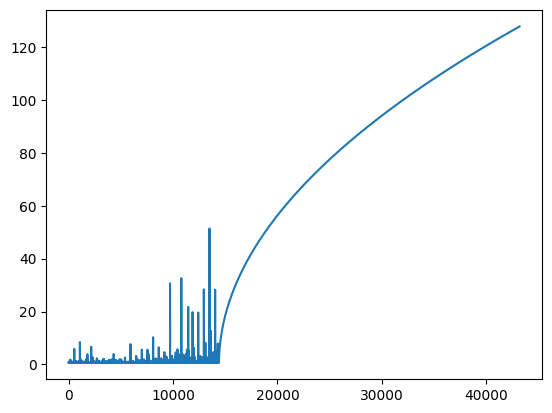

In [248]:
arch1_2_euro = arch_model(train_2_scaled_euro_ret_s, vol = "ARCH", p=1)
arch1_2_euro_results = arch1_2_euro.fit()
euro_2_df["ARCH(1)"] = arch1_2_euro_results.conditional_volatility
arch1_2_euro_fcast = arch1_2_euro_results.forecast(horizon=ntest2, reindex=False)
euro_2_df.loc[test_2_euro_idx, "ARCH(1)"] = np.sqrt(arch1_2_euro_fcast.variance.loc[train_2_euro_df.index[-1]].to_numpy())
euro_2_df["ARCH(1)"].plot()
arch1_2_euro_results.summary()

In [ ]:
### P/R = 1

Iteration:      1,   Func. Count:      5,   Neg. LLF: 27174.897086181867
Iteration:      2,   Func. Count:     13,   Neg. LLF: 11591.749671780799
Iteration:      3,   Func. Count:     20,   Neg. LLF: 7399.8835408375235
Iteration:      4,   Func. Count:     26,   Neg. LLF: 7117.756074415449
Iteration:      5,   Func. Count:     30,   Neg. LLF: 7117.756070624825
Iteration:      6,   Func. Count:     33,   Neg. LLF: 7117.756070624811
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7117.756070624825
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7117.76
Distribution:                  Normal   AIC:                           14241.5
Method:            Maximum Likelihood   BIC:                           14261.1
                                        No. Observations:                 5102
Date:                Wed, May 24 2023   Df Residuals:                     5101
Time:                        17:22:29   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -6.5974e-03  1.376e-02     -0.479      0.632 [-3.357e-02,2.038e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7655  3.436e-02     22.280 5.785e-110 [  0.698,  0.833]
alpha[1]       0.2572  4.145e-02      6.205  5.483e-10 [  0.176,  0.338]
========================================================================

Covariance estimator: robust
"""

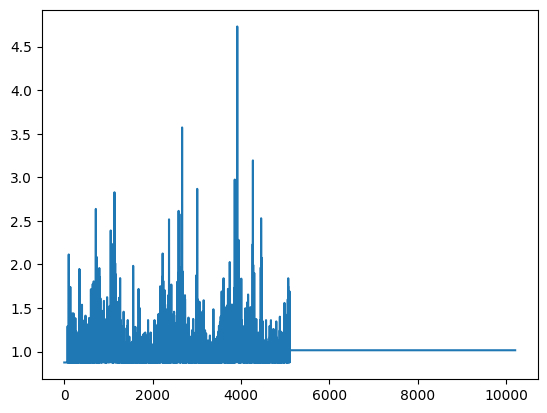

In [45]:
arch1_1_euro = arch_model(train_1_scaled_euro_ret_s, vol = "ARCH", p=1)
arch1_1_euro_results = arch1_1_euro.fit()
euro_1_df.loc[train_1_euro_idx, "ARCH(1) 1"] = arch1_1_euro_results.conditional_volatility
arch1_1_euro_fcast = arch1_1_euro_results.forecast(horizon=ntest1, reindex=False)

euro_1_df.loc[test_1_euro_idx, "ARCH(1) 1"] = np.sqrt(
    arch1_1_euro_fcast.variance.loc[train_1_euro_df.index[-1]].to_numpy())

euro_1_df["ARCH(1) 1"].plot()
arch1_1_euro_results.summary()

In [ ]:
### P/R = 0.4

Iteration:      1,   Func. Count:      5,   Neg. LLF: 38622.06841414697
Iteration:      2,   Func. Count:     13,   Neg. LLF: 12957.107574539074
Iteration:      3,   Func. Count:     21,   Neg. LLF: 11155.647118164434
Iteration:      4,   Func. Count:     28,   Neg. LLF: 10149.205325708175
Iteration:      5,   Func. Count:     31,   Neg. LLF: 10149.205325708179
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10149.205325708175
            Iterations: 5
            Function evaluations: 31
            Gradient evaluations: 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -10149.2
Distribution:                  Normal   AIC:                           20304.4
Method:            Maximum Likelihood   BIC:                           20325.1
                                        No. Observations:                 7288
Date:                Wed, May 24 2023   Df Residuals:                     7287
Time:                        17:22:31   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.2029e-03  1.120e-02     -0.464      0.642 [-2.716e-02,1.675e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7994  4.916e-02     16.261  1.869e-59 [  0.703,  0.896]
alpha[1]       0.2042  3.725e-02      5.482  4.206e-08 [  0.131,  0.277]
========================================================================

Covariance estimator: robust
"""

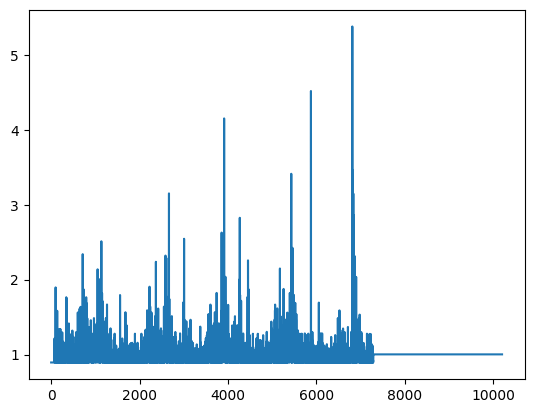

In [46]:
arch1_04_euro = arch_model(train_04_scaled_euro_ret_s, vol = "ARCH", p=1)
arch1_04_euro_results = arch1_04_euro.fit()
euro_04_df.loc[train_04_euro_idx, "ARCH(1) 04"] = arch1_04_euro_results.conditional_volatility
arch1_04_euro_fcast = arch1_04_euro_results.forecast(horizon=ntest04, reindex=False)
euro_04_df.loc[test_04_euro_idx, "ARCH(1) 04"] = np.sqrt(
    arch1_04_euro_fcast.variance.loc[train_04_euro_df.index[-1]].to_numpy())
euro_04_df["ARCH(1) 04"].plot()
arch1_04_euro_results.summary()

## GARCH(1,1)

In [ ]:
### P/R = 2

Iteration:      1,   Func. Count:     11,   Neg. LLF: 510115.05982674117
Iteration:      2,   Func. Count:     25,   Neg. LLF: 24076.444755862685
Iteration:      3,   Func. Count:     36,   Neg. LLF: 15613.190621156777
Iteration:      4,   Func. Count:     47,   Neg. LLF: 113764.08924150914
Iteration:      5,   Func. Count:     60,   Neg. LLF: 307031.06124146533
Iteration:      6,   Func. Count:     76,   Neg. LLF: 109125.08234881704
Iteration:      7,   Func. Count:     87,   Neg. LLF: 24978.181577906802
Iteration:      8,   Func. Count:     98,   Neg. LLF: 24319.026637816103
Iteration:      9,   Func. Count:    109,   Neg. LLF: 23717.01791499868
Iteration:     10,   Func. Count:    120,   Neg. LLF: 25926.087284220364
Iteration:     11,   Func. Count:    131,   Neg. LLF: 24839.163974828694
Iteration:     12,   Func. Count:    142,   Neg. LLF: 26398.30333199542
Iteration:     13,   Func. Count:    153,   Neg. LLF: 11384.664316003742
Iteration:     14,   Func. Count:    164,   Neg. LLF:

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -8698.07
Distribution:      Standardized Student's t   AIC:                           17414.1
Method:                  Maximum Likelihood   BIC:                           17482.3
                                              No. Observations:                14394
Date:                      Wed, Jun 07 2023   Df Residuals:                    14393
Time:                              12:03:37   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -9.7377e-03  2.190e-03     -4.447  8.723e-06 [-1.403e-02,-5.446e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.2446e-03  3.757e-04      3.313  9.236e-04 [5.082e-04,1.981e-03]
alpha[1]       0.1251  2.622e-02      4.772  1.825e-06   [7.374e-02,  0.177]
beta[1]        0.6129      0.290      2.115  3.443e-02   [4.491e-02,  1.181]
beta[2]    4.8226e-04      0.143  3.363e-03      0.997     [ -0.281,  0.282]
beta[3]        0.0000      0.358      0.000      1.000     [ -0.702,  0.702]
beta[4]        0.0000      0.323      0.000      1.000     [ -0.633,  0.633]
beta[5]        0.2615      0.252      1.039      0.299     [ -0.232,  0.755]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.8714      0.179     21.591 2.204e-103 [  3.520,  4.223]
========================================================================

Covariance estimator: robust
"""

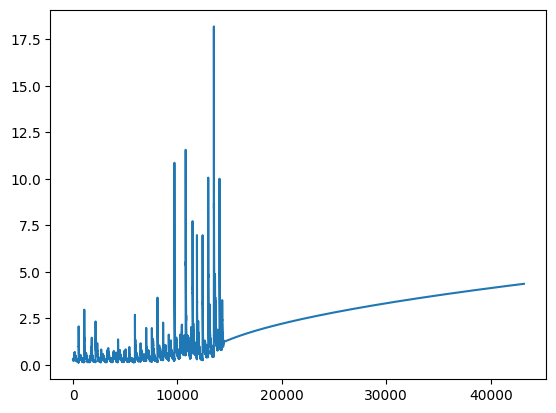

In [249]:
garch11_2_euro = arch_model(train_2_scaled_euro_ret_s, vol = "GARCH", p=1, q=5, dist="studentst")
garch11_2_euro_results = garch11_2_euro.fit()

euro_2_df["GARCH(1,1) 2"] = garch11_2_euro_results.conditional_volatility
garch11_2_euro_fcast = garch11_2_euro_results.forecast(horizon=ntest2, reindex=False)

euro_2_df.loc[test_2_euro_idx, "GARCH(1,1) 2"] = np.sqrt(
    garch11_2_euro_fcast.variance.loc[train_2_euro_df.index[-1]].to_numpy())

euro_2_df["GARCH(1,1) 2"].plot()
garch11_2_euro_results.summary()

In [ ]:
### P/R = 1

In [48]:
#garch_1

Iteration:      1,   Func. Count:      7,   Neg. LLF: 37644.67956732339
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17828.67434927515
Iteration:      3,   Func. Count:     25,   Neg. LLF: 11337.11798498455
Iteration:      4,   Func. Count:     32,   Neg. LLF: 6398.627744503284
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6398.6277442949495
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6398.627744503284
            Iterations: 5
            Function evaluations: 37
            Gradient evaluations: 5


/Users/leonplaza/Desktop/Repositorio GITHUB/messiaen/venv/lib/python3.11/site-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6398.63
Distribution:      Standardized Student's t   AIC:                           12807.3
Method:                  Maximum Likelihood   BIC:                           12839.9
                                              No. Observations:                 5102
Date:                      Wed, May 24 2023   Df Residuals:                     5101
Time:                              17:22:57   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.8897e-03  7.984e-04     12.387  3.060e-35 [8.325e-03,1.145e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.9980e-09  5.059e-07  1.976e-02      0.984 [-9.815e-07,1.002e-06]
alpha[1]       0.0397  1.033e-02      3.840  1.232e-04  [1.942e-02,5.991e-02]
beta[1]        0.9603  1.179e-02     81.449      0.000      [  0.937,  0.983]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.6487      0.364     12.777  2.203e-37 [  3.936,  5.362]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

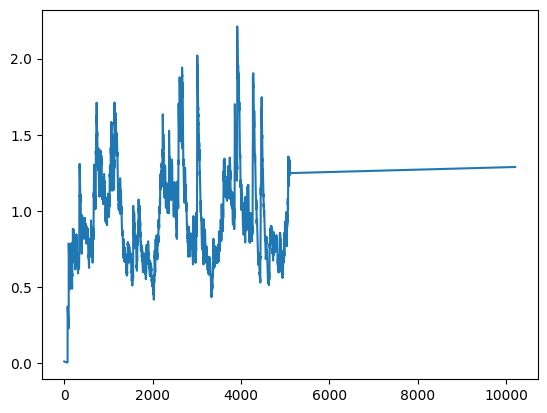

In [53]:
garch11_1_euro = arch_model(train_1_scaled_euro_ret_s, vol = "GARCH", p=1, q=1, dist="studentst")
garch11_1_euro_results = garch11_1_euro.fit()
euro_1_df["GARCH(1,1) 1"] = garch11_1_euro_results.conditional_volatility
garch11_1_euro_fcast = garch11_1_euro_results.forecast(horizon=ntest1, reindex=False)
euro_1_df.loc[test_1_euro_idx, "GARCH(1,1) 1"] = np.sqrt(
    garch11_1_euro_fcast.variance.loc[train_1_euro_df.index[-1]].to_numpy())
euro_1_df["GARCH(1,1) 1"].plot()
garch11_1_euro_results.summary()

In [ ]:
### P/R = 04

Iteration:      1,   Func. Count:      7,   Neg. LLF: 37927.561121609484
Iteration:      2,   Func. Count:     17,   Neg. LLF: 27516.40769947892
Iteration:      3,   Func. Count:     25,   Neg. LLF: 12417.816212906828
Iteration:      4,   Func. Count:     36,   Neg. LLF: 9165.522819181855
Iteration:      5,   Func. Count:     42,   Neg. LLF: 18483.30610425564
Iteration:      6,   Func. Count:     58,   Neg. LLF: 9531.618183875442
Iteration:      7,   Func. Count:     66,   Neg. LLF: 14737.636407241467
Iteration:      8,   Func. Count:     73,   Neg. LLF: 16798.726394867004
Iteration:      9,   Func. Count:     81,   Neg. LLF: 9211.313018518958
Iteration:     10,   Func. Count:     87,   Neg. LLF: 9211.453004450637
Iteration:     11,   Func. Count:     93,   Neg. LLF: 9200.668332603673
Iteration:     12,   Func. Count:     99,   Neg. LLF: 9052.92546076839
Iteration:     13,   Func. Count:    105,   Neg. LLF: 9198.592114251725
Iteration:     14,   Func. Count:    118,   Neg. LLF: 9330.25

/Users/leonplaza/Desktop/Repositorio GITHUB/messiaen/venv/lib/python3.11/site-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -9014.40
Distribution:      Standardized Student's t   AIC:                           18038.8
Method:                  Maximum Likelihood   BIC:                           18073.3
                                              No. Observations:                 7288
Date:                      Wed, May 24 2023   Df Residuals:                     7287
Time:                              17:23:15   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.7821e-04  2.902e-03 -9.586e-02      0.924 [-5.967e-03,5.410e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.5842e-08  2.169e-05  2.114e-03      0.998 [-4.246e-05,4.255e-05]
alpha[1]       0.0381  7.475e-03      5.095  3.496e-07  [2.343e-02,5.273e-02]
beta[1]        0.9608  8.277e-03    116.087      0.000      [  0.945,  0.977]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.3518      0.819      6.532  6.488e-11 [  3.746,  6.958]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

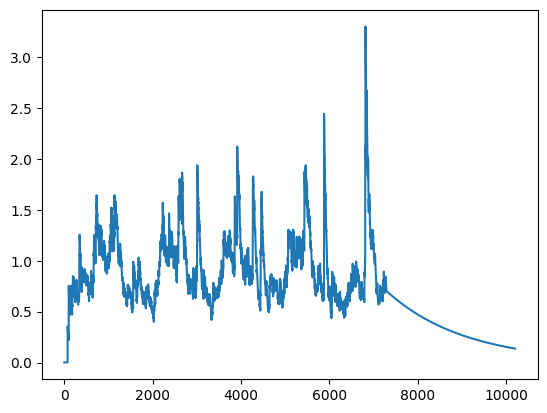

In [54]:
garch11_04_euro = arch_model(train_04_scaled_euro_ret_s, vol = "GARCH", p=1, q=1, dist="studentst")
garch11_04_euro_results = garch11_04_euro.fit()
euro_04_df["GARCH(1,1) 04"] = garch11_04_euro_results.conditional_volatility
garch11_04_euro_fcast = garch11_04_euro_results.forecast(horizon=ntest04, reindex=False)
euro_04_df.loc[test_04_euro_idx, "GARCH(1,1) 04"] = np.sqrt(
    garch11_04_euro_fcast.variance.loc[train_04_euro_df.index[-1]].to_numpy())
euro_04_df["GARCH(1,1) 04"].plot()
garch11_04_euro_results.summary()

## Resumen

In [55]:
aic_arch_ls = [arch1_2_euro_results.aic, arch1_1_euro_results.aic, arch1_04_euro_results.aic]
bic_arch_ls = [arch1_2_euro_results.bic, arch1_1_euro_results.bic, arch1_04_euro_results.bic]
loglh_arch_ls = [arch1_2_euro_results.loglikelihood, arch1_1_euro_results.loglikelihood, 
                 arch1_04_euro_results.loglikelihood]
r2_fit_arch_ls = [arch1_2_euro_results.rsquared, arch1_1_euro_results.rsquared, arch1_04_euro_results.rsquared]
mse_arch_ls = [np.sqrt((arch1_2_euro_results.resid**2).mean()), 
                     np.sqrt((arch1_1_euro_results.resid**2).mean()), 
                     np.sqrt((arch1_04_euro_results.resid**2).mean())]

aic_garch_ls = [garch11_2_euro_results.aic, garch11_1_euro_results.aic, garch11_04_euro_results.aic]
bic_garch_ls = [garch11_2_euro_results.bic, garch11_1_euro_results.bic, garch11_04_euro_results.bic]
loglh_garch_ls = [garch11_2_euro_results.loglikelihood, garch11_1_euro_results.loglikelihood, 
                 garch11_04_euro_results.loglikelihood]
r2_fit_garch_ls = [garch11_2_euro_results.rsquared, garch11_1_euro_results.rsquared, garch11_04_euro_results.rsquared]
mse_garch_ls = [np.sqrt((garch11_2_euro_results.resid**2).mean()), 
                     np.sqrt((garch11_1_euro_results.resid**2).mean()), 
                     np.sqrt((garch11_04_euro_results.resid**2).mean())]

names_df = pd.DataFrame(["AIC IS", "BIC IS","Log Likelihood", "R2", "MSE"]).rename(columns={0:"Metrica"})
garch_name_df = pd.DataFrame({"model":["GARCH (1,1)", "GARCH (1,1)", "GARCH (1,1)", "GARCH (1,1)", "GARCH (1,1)"]})
arch_name_df = pd.DataFrame({"model":["ARCH (1,1)", "ARCH (1,1)", "ARCH (1,1)", "ARCH (1,1)", "ARCH (1,1)"]})

In [56]:
resumen_arch_df = pd.concat([pd.DataFrame(aic_arch_ls), 
           pd.DataFrame(bic_arch_ls),
           pd.DataFrame(loglh_arch_ls),
           pd.DataFrame(r2_fit_arch_ls),
           pd.DataFrame(mse_arch_ls)],
          axis=1).T.reset_index(drop=True)

resumen_arch_df = pd.concat([arch_name_df, resumen_arch_df], axis=1)
resumen_arch_df = pd.concat([names_df, resumen_arch_df,], axis=1).reset_index(drop=True)
resumen_arch_df = resumen_arch_df.set_index("Metrica").rename_axis("Metrica")
resumen_arch_df = resumen_arch_df.rename({0:"P/R=2", 1:"P/R=1", 2:"P/R=0.4", "model":"Model"},axis=1)

resumen_garch_df = pd.concat([pd.DataFrame(aic_garch_ls), 
           pd.DataFrame(bic_garch_ls),
           pd.DataFrame(loglh_garch_ls),
           pd.DataFrame(r2_fit_garch_ls),
           pd.DataFrame(mse_garch_ls)],
          axis=1).T.reset_index(drop=True)

resumen_garch_df = pd.concat([garch_name_df, resumen_garch_df], axis=1)
resumen_garch_df = pd.concat([names_df, resumen_garch_df,], axis=1).reset_index(drop=True)
resumen_garch_df = resumen_garch_df.set_index("Metrica").rename_axis("Metrica")
resumen_garch_df = resumen_garch_df.rename({0:"P/R=2", 1:"P/R=1", 2:"P/R=0.4", "model":"Model"},axis=1)
resumen_volatilidad_df = pd.concat([resumen_arch_df.reset_index(),resumen_garch_df.reset_index()]).set_index(["Model", "Metrica"])

In [57]:
resumen_volatilidad_df

P/R=2         P/R=1       P/R=0.4
Model       Metrica                                                
ARCH (1,1)  AIC IS          9480.673934  14241.512141  20304.410651
            BIC IS          9499.069409  14261.124305  20325.092605
            Log Likelihood -4737.336967  -7117.756071 -10149.205326
            R2                 0.000000      0.000000      0.000000
            MSE                0.999863      0.999924      0.999945
GARCH (1,1) AIC IS          8181.979476  12807.255489  18038.796002
            BIC IS          8212.638600  12839.942429  18073.265925
            Log Likelihood -4085.989738  -6398.627745  -9014.398001
            R2                 0.000000      0.000000      0.000000
            MSE                0.999950      0.999951      0.999931

In [109]:
arch = arch_model(test_04_euro_ret_s, vol = "GARCH", p=1, q=1, dist="studentst")

In [107]:
def garch_metrics(data_s, p, q):
    arch = arch_model(data_s, vol = "GARCH", p=p, q=q, dist="studentst")
    arch_results = arch.fit()
    names_df = pd.DataFrame(["AIC IS", "BIC IS","Log Likelihood", "R2", "MSE"]).rename(columns={0:"Metrica"})
    metrics_ls = arch_results.aic, arch_results.bic, arch_results.loglikelihood, arch_results.rsquared, np.sqrt((arch_results.resid**2).mean())        
    resumen_df = pd.DataFrame(metrics_ls).reset_index(drop=True)
    resumen_df = pd.concat([names_df, resumen_df,], axis=1).reset_index(drop=True)
    resumen_df = resumen_df.set_index("Metrica").rename_axis("Metrica")
    resumen_df = resumen_df.rename({0:f"GARCH({p,q})"},axis=1)
    return resumen_df


garch_metrics(train_04_scaled_euro_ret_s, 3, 3)

Iteration:      1,   Func. Count:     11,   Neg. LLF: 37948.38497296125
Iteration:      2,   Func. Count:     26,   Neg. LLF: 34900.36822504479
Iteration:      3,   Func. Count:     38,   Neg. LLF: 17781.892606176152
Iteration:      4,   Func. Count:     49,   Neg. LLF: 9452.365905189377
Iteration:      5,   Func. Count:     60,   Neg. LLF: 9401.560985411037
Iteration:      6,   Func. Count:     71,   Neg. LLF: 10470.538556847012
Iteration:      7,   Func. Count:     83,   Neg. LLF: 9289.438457275479
Iteration:      8,   Func. Count:     93,   Neg. LLF: 16550.725815955844
Iteration:      9,   Func. Count:    113,   Neg. LLF: 23608.905796843224
Iteration:     10,   Func. Count:    128,   Neg. LLF: 9284.294914702385
Iteration:     11,   Func. Count:    139,   Neg. LLF: 17172.571051380288
Iteration:     12,   Func. Count:    150,   Neg. LLF: 9140.68785341825
Iteration:     13,   Func. Count:    161,   Neg. LLF: 9125.385284328975
Iteration:     14,   Func. Count:    171,   Neg. LLF: 9118.0

/Users/leonplaza/Desktop/Repositorio GITHUB/messiaen/venv/lib/python3.11/site-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,"GARCH((3, 3))"
Metrica,
AIC IS,17836.510475
BIC IS,17898.556335
Log Likelihood,-8909.255237
R2,0.000000
MSE,0.999931


In [105]:
resumen_volatilidad_df

P/R=2         P/R=1       P/R=0.4
Model       Metrica                                                
ARCH (1,1)  AIC IS          9480.673934  14241.512141  20304.410651
            BIC IS          9499.069409  14261.124305  20325.092605
            Log Likelihood -4737.336967  -7117.756071 -10149.205326
            R2                 0.000000      0.000000      0.000000
            MSE                0.999863      0.999924      0.999945
GARCH (1,1) AIC IS          8181.979476  12807.255489  18038.796002
            BIC IS          8212.638600  12839.942429  18073.265925
            Log Likelihood -4085.989738  -6398.627745  -9014.398001
            R2                 0.000000      0.000000      0.000000
            MSE                0.999950      0.999951      0.999931

#
22:58  -  16:27

In [287]:
df1 = pd.read_csv(r"/Users/leonplaza/Desktop/Repositorio GITHUB/messiaen/GBR.csv", index_col="datetime", parse_dates=True)
libra_df = df1.pivot_table(values="price_close", index=["eod_id", "datetime"]).droplevel(0).resample("T").last().ffill()
libra_df = libra_df.drop(pd.date_range(start="2022/01/07 22:01:00", end="2022/01/08 08:17:00", freq="T"), axis=0).copy()
libra_df = libra_df.drop(pd.date_range(start="2022/01/08 08:22:00", end="2022/01/09 19:59:00", freq="T"), axis=0).copy()
libra_df = libra_df.drop(pd.date_range(start="2022/01/11 15:57:00", end="2022/01/12 15:56:00", freq="T"), axis=0).copy()
libra_df = libra_df.reset_index()
libra_df["log_return"] = np.log(libra_df["price_close"]).diff()
libra_df = libra_df.drop("price_close", axis=1).iloc[1:]

var_euro_df = pd.concat([libra_df.set_index("datetime").rename({"log_return":"Euro"}, axis=1),
                         euro_df.set_index("datetime").rename({"log_return":"GBR"}, axis=1)], 
                        axis=1).dropna().reset_index()
minutes_s = var_euro_df.reset_index()["datetime"].diff().apply(lambda x: x.seconds / 60 if not pd.isnull(x) else 0)
for i in range(len(minutes_s)):
    if minutes_s[i] > 1:
        print(i, minutes_s[i])
        
var_euro_df = var_euro_df.drop("datetime", axis=1)

scaled_gbr = StandardScaler()
var_euro_df["Scaled GBR"] = scaled_gbr.fit_transform(var_euro_df[["GBR"]])
scaled_euro = StandardScaler()
var_euro_df["Scaled EUR"] = scaled_euro.fit_transform(var_euro_df[["Euro"]])
var_euro_df = var_euro_df.drop(["Euro","GBR"], axis=1)

7319 1118.0


In [288]:
print(var_euro_df.corr())

            Scaled GBR  Scaled EUR
Scaled GBR    1.000000    0.371889
Scaled EUR    0.371889    1.000000


In [289]:
granger_results2 = grangercausalitytests(var_euro_df[["Scaled EUR", "Scaled GBR"]], maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.1022 , p=0.0000  , df_denom=8745, df_num=1
ssr based chi2 test:   chi2=20.1091 , p=0.0000  , df=1
likelihood ratio test: chi2=20.0860 , p=0.0000  , df=1
parameter F test:         F=20.1022 , p=0.0000  , df_denom=8745, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.0621 , p=0.0000  , df_denom=8742, df_num=2
ssr based chi2 test:   chi2=42.1483 , p=0.0000  , df=2
likelihood ratio test: chi2=42.0470 , p=0.0000  , df=2
parameter F test:         F=21.0621 , p=0.0000  , df_denom=8742, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=16.1104 , p=0.0000  , df_denom=8739, df_num=3
ssr based chi2 test:   chi2=48.3699 , p=0.0000  , df=3
likelihood ratio test: chi2=48.2366 , p=0.0000  , df=3
parameter F test:         F=16.1104 , p=0.0000  , df_denom=8739, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=12.2076 , p=0.

In [ ]:
granger_results2 = grangercausalitytests(, maxlag=18)

In [ ]:
granger_results2 = grangercausalitytests(macro_df[["TSpread", "GDPGrowth"]], maxlag=18)

In [157]:
var_euro_df

,datetime,Ret GBR,Ret EUR,Scaled GBR,Scaled EUR
0,2022-01-02 21:17:00,0.000510,0.000238,3.628191,1.552251
1,2022-01-02 21:42:00,0.000155,0.000484,1.096538,3.165521
2,2022-01-02 22:00:00,0.000000,0.000000,-0.010531,-0.004506
3,2022-01-02 22:07:00,-0.000414,0.000255,-2.963097,1.666345
4,2022-01-02 22:32:00,0.000074,0.000132,0.516802,0.859560
...,...,...,...,...,...
8531,2022-01-12 16:23:00,-0.000073,-0.000035,-0.531378,-0.233817
8532,2022-01-12 16:24:00,-0.000066,-0.000053,-0.479326,-0.348488
8533,2022-01-12 16:25:00,0.000000,0.000096,-0.010531,0.626114
8534,2022-01-12 16:26:00,0.000124,0.000009,0.874944,0.052820
